# Kendall's tau-based distance (RR/CXR)

- **RR-RR (Intra)**: RR run들끼리 distance 분포
- **RR-CXR (Inter)**: RR run vs CXR(img) run distance 분포
- **CXR-CXR (Intra)**: CXR(img) run들끼리 distance 분포

> Distance 정의: \(d = (1 - \tau) / 2\) (Kendall's \(\tau\) 기반, \([0,1]\) 범위)

이 노트북은 `trained_models/rr/<run_id>/plain_{split}_predictions.txt` (및 `trained_models/img/<run_id>/...`) 를 자동 탐색해서, **self 제외 ordered pair**로 \(n(n-1)\) 개(예: 10이면 90개) distance를 만들고 violin plot(호리병 모양)으로 시각화합니다.

In [1]:
import json
from pathlib import Path
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from scipy.stats import kendalltau
except Exception as e:
    kendalltau = None
    print("Warning: scipy not available; please install scipy for kendalltau:", e)

# --- Global style (tone & manner shared across notebooks) ---
sns.set_theme(
    style="whitegrid",
    context="talk",
    font_scale=0.95,
    rc={
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "grid.alpha": 0.35,
        "axes.grid": True,
    },
)
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True

In [2]:
BASE = Path('/chanhwi/CXR_info_disparity/trained_models')
SPLIT = 'test'   # 'dev' or 'test'

RR_DIR = BASE / 'rr'
IMG_DIR = BASE / 'img'

PRED_BASENAME = 'plain_{split}_predictions.txt'  # matches your inference outputs

# Plot order
CATEGORY_ORDER = ['RR-RR (Intra)', 'RR-CXR (Inter)', 'CXR-CXR (Intra)']

# Tone & manner palette (match your figure style)
PALETTE = {
    'RR-RR (Intra)': '#2E86AB',
    'RR-CXR (Inter)': '#C73E1D',
    'CXR-CXR (Intra)': '#6A994E',
}

In [3]:
def discover_runs(modality_dir: Path, include_root: bool = False):
    """Return list of run paths under modality_dir.

    - Numeric subfolders (e.g., 1..10) are treated as runs
    - Optionally include modality_dir itself if it contains prediction files
    """
    runs = []

    if include_root:
        runs.append(modality_dir)

    if modality_dir.exists():
        for p in modality_dir.iterdir():
            if p.is_dir() and p.name.isdigit():
                runs.append(p)

    # sort numeric runs by int, keep root first if present
    def sort_key(p: Path):
        return (-1, 0) if p == modality_dir else (0, int(p.name))

    runs = sorted(runs, key=sort_key)
    return runs


def load_scores(run_dir: Path, split: str = 'test') -> pd.Series:
    """Load positive-class probability per sample id as a Series indexed by id."""
    pred_path = run_dir / PRED_BASENAME.format(split=split)
    if not pred_path.exists():
        raise FileNotFoundError(str(pred_path))

    ids = []
    scores = []

    with pred_path.open('r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            ex = json.loads(line)
            ids.append(ex['id'])
            # probabilities[1] = positive class prob
            scores.append(float(ex['probabilities'][1]))

    s = pd.Series(scores, index=pd.Index(ids, name='id'), name=run_dir.name)
    # If duplicates, keep last
    s = s[~s.index.duplicated(keep='last')]
    return s


def kendall_tau_distance(a: pd.Series, b: pd.Series):
    """Compute Kendall's tau and tau-based distance d=(1-tau)/2 after aligning ids."""
    if kendalltau is None:
        raise RuntimeError('scipy is required for kendalltau; please `pip install scipy`.')

    common = a.index.intersection(b.index)
    a2 = a.loc[common].to_numpy()
    b2 = b.loc[common].to_numpy()

    # kendalltau returns (tau, pvalue)
    tau, _ = kendalltau(a2, b2, nan_policy='omit')
    if tau is None or np.isnan(tau):
        return np.nan, np.nan, len(common)

    d = (1.0 - float(tau)) / 2.0
    return float(tau), float(d), int(len(common))


PAIRWISE_COLUMNS = ['modality', 'model_i', 'model_j', 'tau', 'distance', 'n_common']


def pairwise_distance_df(series_map: dict, ordered: bool = True, include_self: bool = False, modality: str = ''):
    """Compute pairwise distances within a modality.

    - ordered=True => i->j and j->i both included (n*(n-1) when include_self=False)
    """
    keys = list(series_map.keys())
    rows = []

    if ordered:
        pairs = itertools.product(keys, keys)
    else:
        pairs = itertools.combinations(keys, 2)

    for i, j in pairs:
        if (not include_self) and (i == j):
            continue
        tau, d, n_common = kendall_tau_distance(series_map[i], series_map[j])
        rows.append({
            'modality': modality,
            'model_i': i,
            'model_j': j,
            'tau': tau,
            'distance': d,
            'n_common': n_common,
        })

    return pd.DataFrame(rows, columns=PAIRWISE_COLUMNS)


def cross_distance_df(map_a: dict, map_b: dict, ordered: bool = True, modality_a: str = '', modality_b: str = ''):
    """Compute cross distances between two modalities."""
    rows = []
    for i, j in itertools.product(list(map_a.keys()), list(map_b.keys())):
        tau, d, n_common = kendall_tau_distance(map_a[i], map_b[j])
        rows.append({
            'modality': f'{modality_a}-{modality_b}',
            'model_i': i,
            'model_j': j,
            'tau': tau,
            'distance': d,
            'n_common': n_common,
        })
        if ordered:
            # add reverse order too (optional) — if you want directional counting symmetry
            # For inter, many people prefer just NxM; keep ordered=False here if you want only NxM.
            pass

    return pd.DataFrame(rows, columns=PAIRWISE_COLUMNS)

In [4]:
def load_available_runs(modality_dir: Path, split: str, include_root: bool = False):
    """Discover runs and load those that actually have prediction files."""
    runs = discover_runs(modality_dir, include_root=include_root)
    series_map = {}
    missing = []

    for run in runs:
        try:
            s = load_scores(run, split=split)
            # Use a stable name (e.g., 'rr/1' not just '1') to avoid collisions
            key = f'{modality_dir.name}/{run.name}' if run != modality_dir else f'{modality_dir.name}/root'
            series_map[key] = s
        except FileNotFoundError:
            missing.append(str(run))

    return series_map, missing


rr_map, rr_missing = load_available_runs(RR_DIR, split=SPLIT, include_root=False)
img_map, img_missing = load_available_runs(IMG_DIR, split=SPLIT, include_root=False)

print('RR runs loaded:', len(rr_map), 'missing:', len(rr_missing))
print('IMG runs loaded:', len(img_map), 'missing:', len(img_missing))

# Expectation: if rr has 10 runs with predictions, RR ordered pairs excluding self = 10*9 = 90
print('RR ordered pairs (exclude self):', len(rr_map) * max(len(rr_map) - 1, 0))
print('IMG ordered pairs (exclude self):', len(img_map) * max(len(img_map) - 1, 0))
print('RR-IMG cross pairs:', len(rr_map) * len(img_map))

RR runs loaded: 10 missing: 0
IMG runs loaded: 0 missing: 6
RR ordered pairs (exclude self): 90
IMG ordered pairs (exclude self): 0
RR-IMG cross pairs: 0


In [5]:
intra_rr = pairwise_distance_df(rr_map, ordered=True, include_self=False, modality='rr')
intra_rr['Category'] = 'RR-RR (Intra)'

intra_img = pairwise_distance_df(img_map, ordered=True, include_self=False, modality='img')
intra_img['Category'] = 'CXR-CXR (Intra)'

inter_rr_img = cross_distance_df(rr_map, img_map, ordered=False, modality_a='rr', modality_b='img')
inter_rr_img['Category'] = 'RR-CXR (Inter)'

all_df = pd.concat([intra_rr, inter_rr_img, intra_img], ignore_index=True)

# Drop NaNs (can happen if kendalltau returns NaN)
all_df = all_df.dropna(subset=['distance']).copy()

print(all_df.groupby('Category').size())
all_df.head()

Category
RR-RR (Intra)    90
dtype: int64


,modality,model_i,model_j,tau,distance,n_common,Category
0,rr,rr/1,rr/2,0.780338,0.109831,1360,RR-RR (Intra)
1,rr,rr/1,rr/3,0.755475,0.122262,1360,RR-RR (Intra)
2,rr,rr/1,rr/4,0.792273,0.103864,1360,RR-RR (Intra)
3,rr,rr/1,rr/5,0.804237,0.097881,1360,RR-RR (Intra)
4,rr,rr/1,rr/6,0.570699,0.214651,1360,RR-RR (Intra)


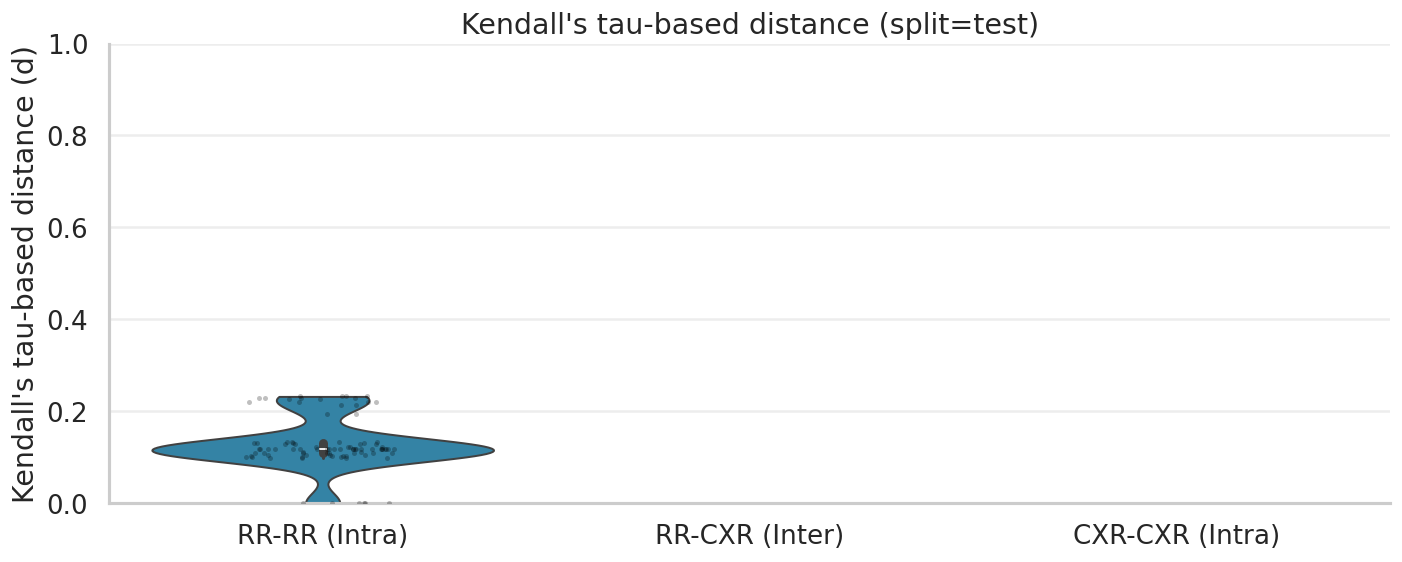

In [6]:
def plot_violin(df: pd.DataFrame, title: str = None):
    fig, ax = plt.subplots(figsize=(12, 5))

    if df is None or len(df) == 0:
        ax.text(0.5, 0.5, 'No pairwise distances to plot', ha='center', va='center')
        ax.set_axis_off()
        return fig

    # Seaborn v0.14+ warning fix: if you pass palette, also pass hue.
    sns.violinplot(
        data=df,
        x='Category',
        y='distance',
        hue='Category',
        order=CATEGORY_ORDER,
        palette=PALETTE,
        cut=0,
        inner='box',
        linewidth=1.2,
        saturation=0.9,
        legend=False,
        ax=ax,
    )

    sns.stripplot(
        data=df,
        x='Category',
        y='distance',
        order=CATEGORY_ORDER,
        color='black',
        alpha=0.25,
        size=3,
        jitter=0.18,
        ax=ax,
    )

    ax.set_ylabel("Kendall's tau-based distance (d)")
    ax.set_xlabel("")
    if title:
        ax.set_title(title)

    ax.set_ylim(0, 1)
    ax.grid(True, axis='y', alpha=0.35)
    sns.despine(ax=ax)

    plt.tight_layout()
    return fig

fig = plot_violin(
    all_df,
    title=f"Kendall's tau-based distance (split={SPLIT})",
)
plt.show()

In [7]:
# DN, DN+RR, DN+IMG 폴더 경로
DN_DIR = BASE / 'dn'
DN_RR_DIR = BASE / 'dn+rr'
DN_IMG_DIR = BASE / 'dn+img'

# 각 모델의 prediction 로드
def load_single_model_scores(model_dir: Path, split: str = 'test') -> pd.Series:
    """Load scores from a single model directory (no run subfolders)."""
    pred_path = model_dir / PRED_BASENAME.format(split=split)
    if not pred_path.exists():
        raise FileNotFoundError(str(pred_path))
    
    ids = []
    scores = []
    
    with pred_path.open('r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            ex = json.loads(line)
            ids.append(ex['id'])
            scores.append(float(ex['probabilities'][1]))
    
    s = pd.Series(scores, index=pd.Index(ids, name='id'), name=model_dir.name)
    s = s[~s.index.duplicated(keep='last')]
    return s

# 각 모델 로드
dn_scores = load_single_model_scores(DN_DIR, split=SPLIT)
dn_rr_scores = load_single_model_scores(DN_RR_DIR, split=SPLIT)
dn_img_scores = load_single_model_scores(DN_IMG_DIR, split=SPLIT)

print(f"DN samples: {len(dn_scores)}")
print(f"DN+RR samples: {len(dn_rr_scores)}")
print(f"DN+IMG samples: {len(dn_img_scores)}")

DN samples: 1360
DN+RR samples: 1360
DN+IMG samples: 1360


In [8]:
# 모든 쌍에 대해 tau distance 계산
pairs = [
    ('DN', 'DN+RR', dn_scores, dn_rr_scores),
    ('DN', 'DN+IMG', dn_scores, dn_img_scores),
    ('DN+RR', 'DN+IMG', dn_rr_scores, dn_img_scores),
]

pair_results = []
for name_a, name_b, scores_a, scores_b in pairs:
    tau, dist, n_common = kendall_tau_distance(scores_a, scores_b)
    pair_results.append({
        'Pair': f'{name_a} vs {name_b}',
        'Model A': name_a,
        'Model B': name_b,
        'tau': tau,
        'distance': dist,
        'n_common': n_common,
    })

pair_df = pd.DataFrame(pair_results)
pair_df

,Pair,Model A,Model B,tau,distance,n_common
0,DN vs DN+RR,DN,DN+RR,0.604433,0.197783,1360
1,DN vs DN+IMG,DN,DN+IMG,0.686882,0.156559,1360
2,DN+RR vs DN+IMG,DN+RR,DN+IMG,0.567409,0.216295,1360


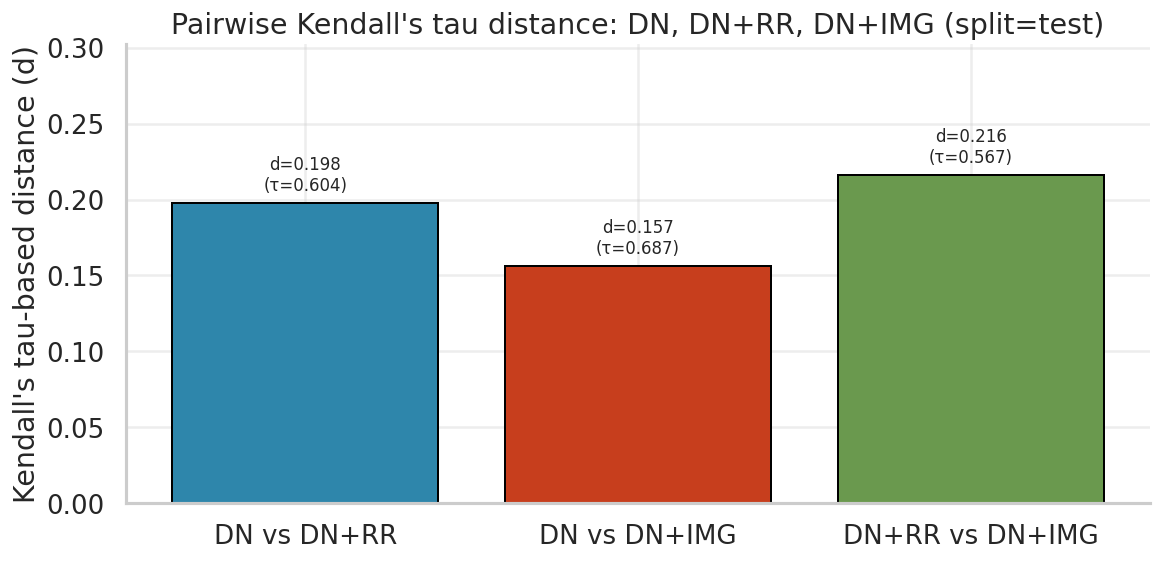

In [9]:
# Bar plot 시각화
PAIR_PALETTE = {
    'DN vs DN+RR': '#2E86AB',
    'DN vs DN+IMG': '#C73E1D',
    'DN+RR vs DN+IMG': '#6A994E',
}

fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(
    pair_df['Pair'],
    pair_df['distance'],
    color=[PAIR_PALETTE.get(p, '#888888') for p in pair_df['Pair']],
    edgecolor='black',
    linewidth=1.2,
)

# 값 표시
for bar, (_, row) in zip(bars, pair_df.iterrows()):
    height = bar.get_height()
    ax.annotate(
        f'd={row["distance"]:.3f}\n(τ={row["tau"]:.3f})',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=10,
    )

ax.set_ylabel("Kendall's tau-based distance (d)")
ax.set_xlabel("")
ax.set_title(f"Pairwise Kendall's tau distance: DN, DN+RR, DN+IMG (split={SPLIT})")
ax.set_ylim(0, max(pair_df['distance']) * 1.4)
ax.grid(True, axis='y', alpha=0.35)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

In [10]:
# ============================================================
# 공통 데이터 준비: Labels 로드 + prob_df 구성
# ============================================================

def load_labels(model_dir: Path, split: str = 'test') -> pd.Series:
    """Load true labels from predictions file."""
    pred_path = model_dir / PRED_BASENAME.format(split=split)
    ids, lbls = [], []
    with pred_path.open('r') as f:
        for line in f:
            if not line.strip():
                continue
            ex = json.loads(line)
            ids.append(ex['id'])
            lbls.append(int(ex['label']))
    return pd.Series(lbls, index=pd.Index(ids, name='id'), name='label')

# Common IDs across all models
common_ids = dn_scores.index.intersection(dn_rr_scores.index).intersection(dn_img_scores.index)

# Labels 로드
labels = load_labels(DN_DIR, split=SPLIT)
labels = labels.loc[common_ids]

# prob_df 구성
prob_df = pd.DataFrame({
    'DN': dn_scores.loc[common_ids],
    'DN+RR': dn_rr_scores.loc[common_ids],
    'DN+IMG': dn_img_scores.loc[common_ids],
    'label': labels,
})

print(f"Common samples: {len(common_ids)}")
print(f"Label distribution: {prob_df['label'].value_counts().to_dict()}")
print(f"Mortality rate: {prob_df['label'].mean():.2%}")

Common samples: 1360
Label distribution: {0: 1300, 1: 60}
Mortality rate: 4.41%


# 모델 간 예측 확률 비교 시각화

DN, DN+RR, DN+IMG 모델이 예측하는 환자별 사망 확률 차이를 다양한 방식으로 비교합니다.

- **Log-odds 변환**: 0 근처에 몰린 확률을 펼쳐서 시각화
- **Reclassification**: CXR/RR 추가가 예측 개선에 얼마나 도움됐는지
- **NRI**: 정량적 개선 지표

## 1. Label별 확률 분포 (Violin Plot)

각 모델이 Died(1) vs Survived(0) 환자를 얼마나 잘 분리하는지 확인합니다.

/tmp/ipykernel_2088379/692157805.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='Label', y='Probability', ax=ax,
/tmp/ipykernel_2088379/692157805.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='Label', y='Probability', ax=ax,
/tmp/ipykernel_2088379/692157805.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='Label', y='Probability', ax=ax,


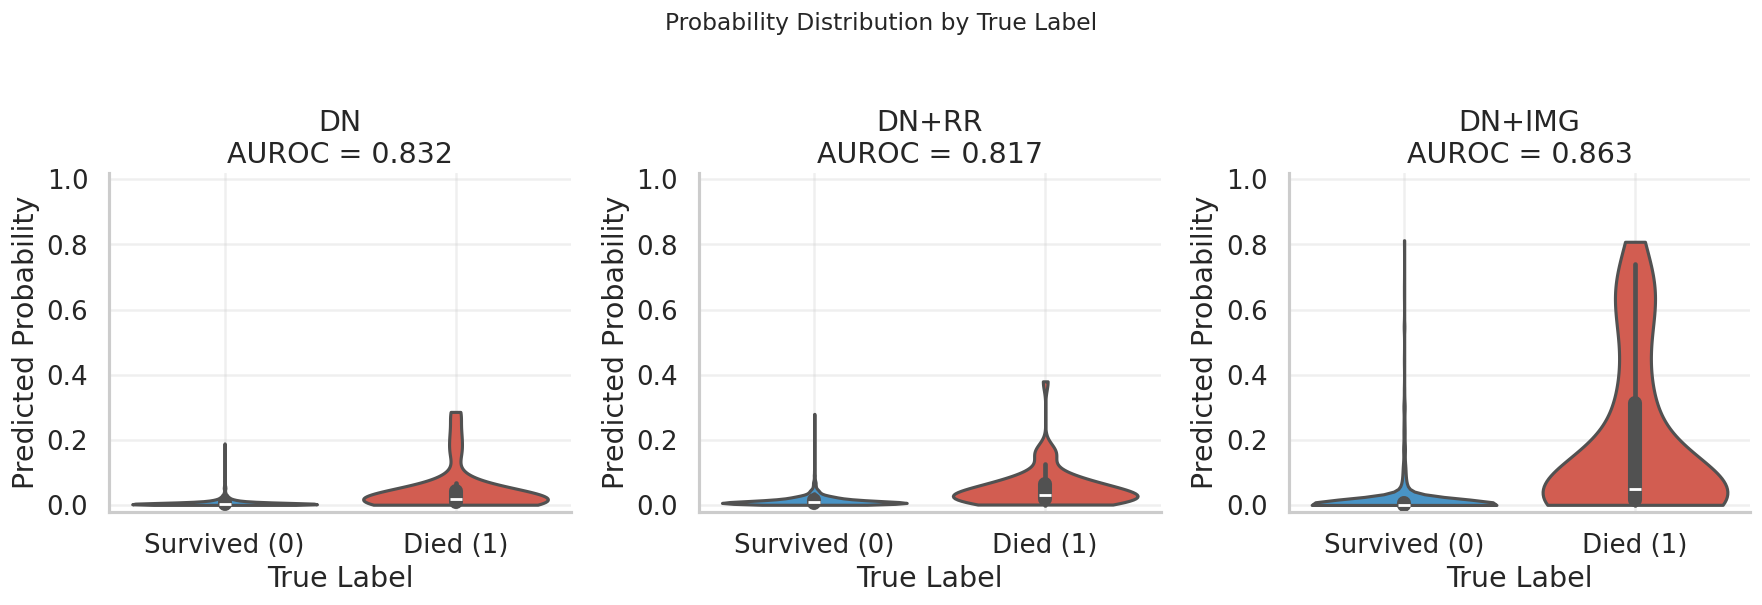

In [11]:
# Label별 확률 분포 - Violin Plot
from sklearn.metrics import roc_auc_score

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
models = ['DN', 'DN+RR', 'DN+IMG']
model_colors = {'DN': '#2E86AB', 'DN+RR': '#C73E1D', 'DN+IMG': '#6A994E'}

for ax, m in zip(axes, models):
    # AUROC 계산
    auroc = roc_auc_score(prob_df['label'], prob_df[m])
    
    # Violin plot
    plot_data = pd.DataFrame({
        'Probability': prob_df[m],
        'Label': prob_df['label'].map({0: 'Survived (0)', 1: 'Died (1)'})
    })
    
    sns.violinplot(data=plot_data, x='Label', y='Probability', ax=ax,
                   palette={'Survived (0)': '#3498db', 'Died (1)': '#e74c3c'},
                   inner='box', cut=0)
    
    ax.set_title(f'{m}\nAUROC = {auroc:.3f}')
    ax.set_xlabel('True Label')
    ax.set_ylabel('Predicted Probability')
    ax.set_ylim(-0.02, 1.02)
    ax.grid(True, alpha=0.3)

plt.suptitle('Probability Distribution by True Label', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## 2. Log-odds (Logit) 변환 Scatter Plot

확률 p → log(p / (1-p))로 변환하면 0 근처에 몰린 값들이 펼쳐져서 차이가 더 잘 보입니다.

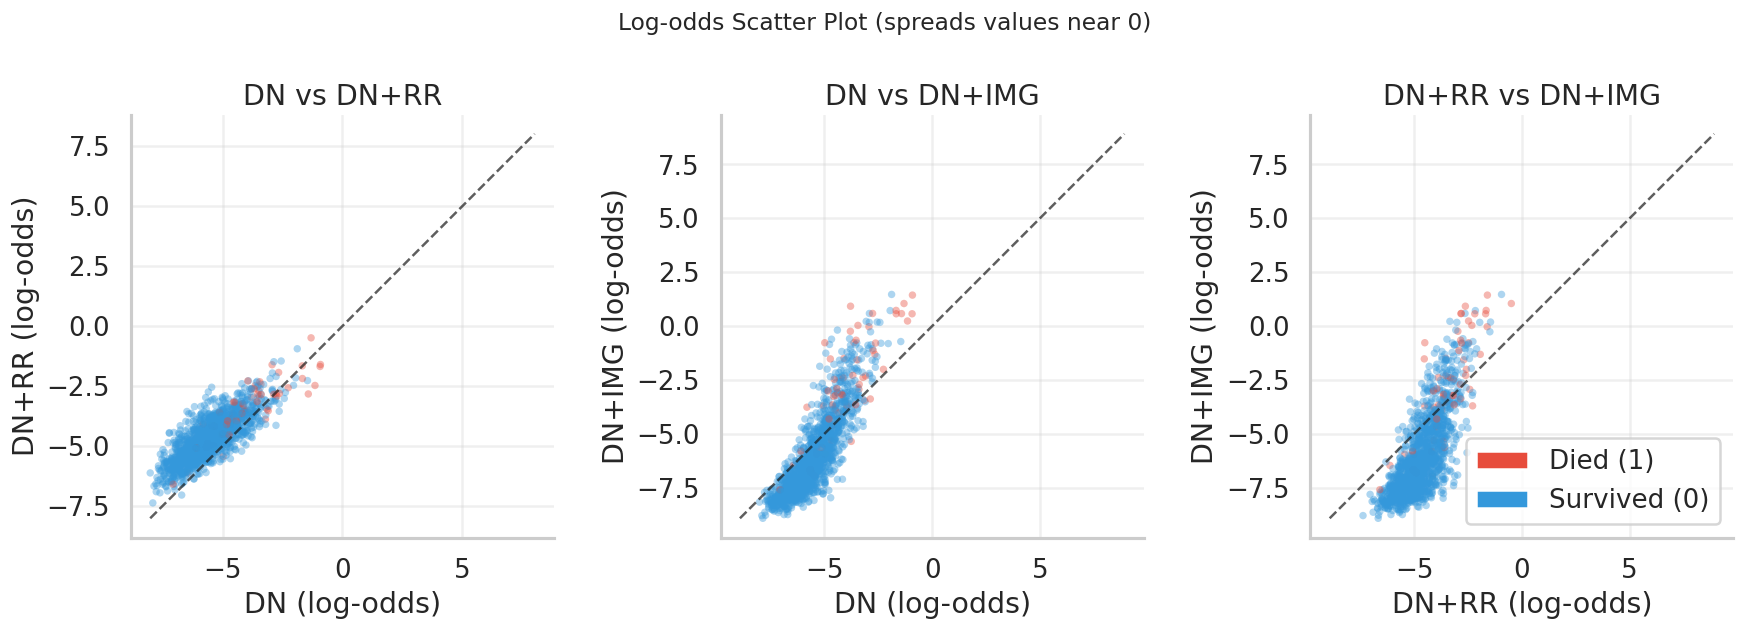

In [12]:
# Log-odds (Logit) 변환
def safe_logit(p, eps=1e-7):
    """Convert probability to log-odds, clipping to avoid inf."""
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

# Logit 변환 적용
prob_df['DN_logit'] = safe_logit(prob_df['DN'])
prob_df['DN+RR_logit'] = safe_logit(prob_df['DN+RR'])
prob_df['DN+IMG_logit'] = safe_logit(prob_df['DN+IMG'])

# Scatter plot (Logit scale)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

logit_pairs = [
    ('DN_logit', 'DN+RR_logit', 'DN vs DN+RR'),
    ('DN_logit', 'DN+IMG_logit', 'DN vs DN+IMG'),
    ('DN+RR_logit', 'DN+IMG_logit', 'DN+RR vs DN+IMG'),
]
pair_colors = ['#2E86AB', '#C73E1D', '#6A994E']

for ax, (m1, m2, title), color in zip(axes, logit_pairs, pair_colors):
    # Label별 색상
    colors = prob_df['label'].map({0: '#3498db', 1: '#e74c3c'})
    
    ax.scatter(prob_df[m1], prob_df[m2], c=colors, alpha=0.4, s=20, edgecolors='none')
    
    # Diagonal
    lim = max(abs(prob_df[m1].min()), abs(prob_df[m1].max()), 
              abs(prob_df[m2].min()), abs(prob_df[m2].max()))
    ax.plot([-lim, lim], [-lim, lim], 'k--', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel(m1.replace('_logit', '') + ' (log-odds)')
    ax.set_ylabel(m2.replace('_logit', '') + ' (log-odds)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='Died (1)'),
                   Patch(facecolor='#3498db', label='Survived (0)')]
axes[2].legend(handles=legend_elements, loc='lower right')

plt.suptitle('Log-odds Scatter Plot (spreads values near 0)', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## 3. Reclassification Scatter Plot (핵심!)

x축 = Base 모델 확률, y축 = Enhanced 모델 확률
- 🔴 Died 환자가 대각선 **위**에 있으면 → 모달리티 추가가 도움됨
- 🔵 Survived 환자가 대각선 **아래**에 있으면 → 모달리티 추가가 도움됨

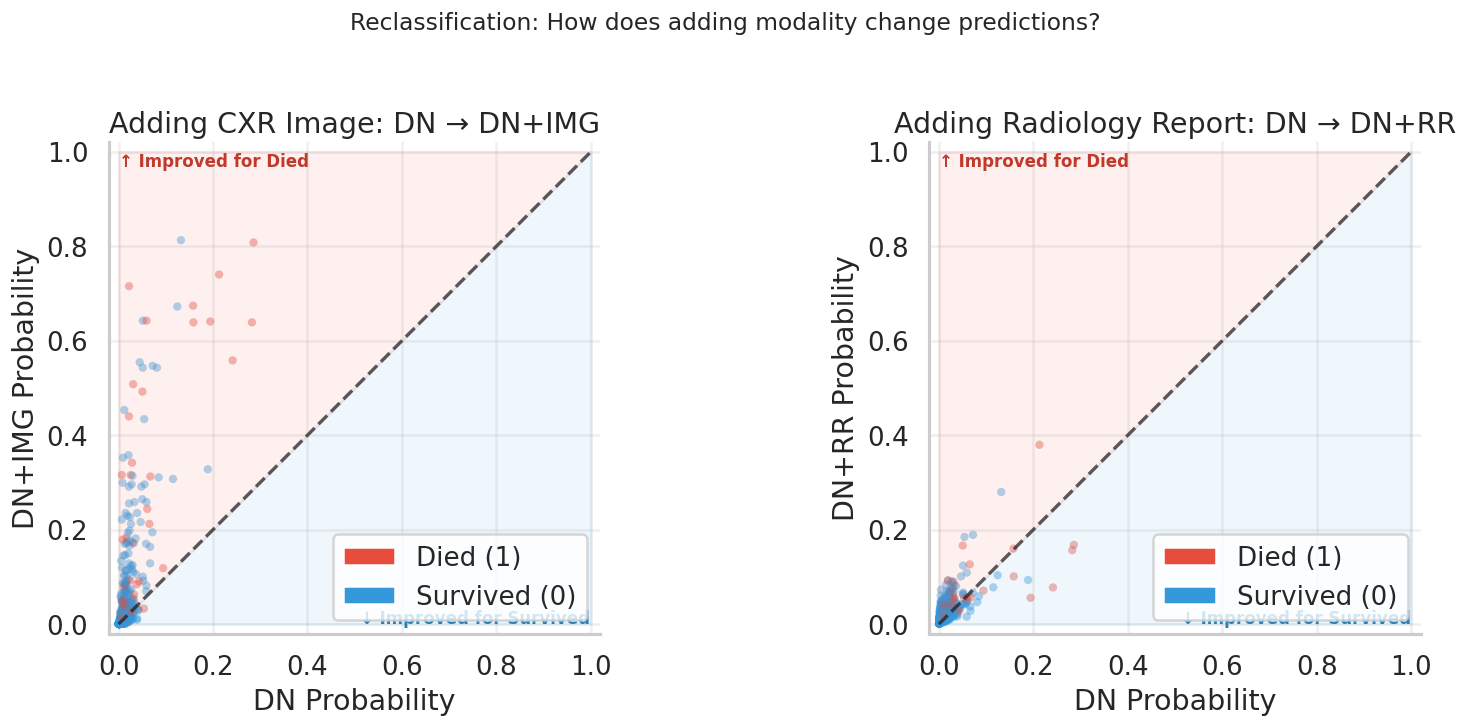

In [13]:
# Reclassification Scatter Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

comparisons = [
    ('DN', 'DN+IMG', 'Adding CXR Image'),
    ('DN', 'DN+RR', 'Adding Radiology Report'),
]

for ax, (base, target, title) in zip(axes, comparisons):
    # Label별 색상
    colors = prob_df['label'].map({0: '#3498db', 1: '#e74c3c'})
    
    ax.scatter(prob_df[base], prob_df[target], c=colors, alpha=0.4, s=25, edgecolors='none')
    
    # Diagonal line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.7)
    
    # 개선 영역 표시
    ax.fill_between([0, 1], [0, 1], [1, 1], alpha=0.08, color='#e74c3c')  # Died 개선 영역
    ax.fill_between([0, 1], [0, 0], [0, 1], alpha=0.08, color='#3498db')  # Survived 개선 영역
    
    # Quadrant labels
    ax.text(0.02, 0.98, '↑ Improved for Died', transform=ax.transAxes, 
            fontsize=10, va='top', color='#c0392b', fontweight='bold')
    ax.text(0.98, 0.02, '↓ Improved for Survived', transform=ax.transAxes, 
            fontsize=10, ha='right', color='#2980b9', fontweight='bold')
    
    ax.set_xlabel(f'{base} Probability')
    ax.set_ylabel(f'{target} Probability')
    ax.set_title(f'{title}: {base} → {target}')
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Legend
    legend_elements = [Patch(facecolor='#e74c3c', label='Died (1)'),
                       Patch(facecolor='#3498db', label='Survived (0)')]
    ax.legend(handles=legend_elements, loc='lower right')

plt.suptitle('Reclassification: How does adding modality change predictions?', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## 4. "Who Benefited?" 분석 + NRI (Net Reclassification Improvement)

- **Died 환자**: 확률이 올라가면 개선 (true positive 방향)
- **Survived 환자**: 확률이 내려가면 개선 (true negative 방향)

**NRI** = (Events에서 개선 비율 - 악화 비율) + (Non-events에서 개선 비율 - 악화 비율)

In [14]:
# NRI 및 "Who Benefited" 분석
def compute_nri_continuous(base_col: str, target_col: str, df: pd.DataFrame):
    """Compute continuous NRI (category-free NRI)."""
    died = df['label'] == 1
    survived = df['label'] == 0
    
    # Difference
    delta = df[target_col] - df[base_col]
    
    # Events (Died): 확률이 올라가면 개선
    events_up = (delta[died] > 0).sum()
    events_down = (delta[died] < 0).sum()
    events_total = died.sum()
    
    # Non-events (Survived): 확률이 내려가면 개선
    non_events_down = (delta[survived] < 0).sum()
    non_events_up = (delta[survived] > 0).sum()
    non_events_total = survived.sum()
    
    # NRI components
    nri_events = (events_up - events_down) / events_total if events_total > 0 else 0
    nri_non_events = (non_events_down - non_events_up) / non_events_total if non_events_total > 0 else 0
    nri_total = nri_events + nri_non_events
    
    return {
        'base': base_col,
        'target': target_col,
        'events_improved': events_up,
        'events_worsened': events_down,
        'events_total': events_total,
        'non_events_improved': non_events_down,
        'non_events_worsened': non_events_up,
        'non_events_total': non_events_total,
        'NRI_events': nri_events,
        'NRI_non_events': nri_non_events,
        'NRI_total': nri_total,
    }

# 각 비교에 대해 NRI 계산
nri_comparisons = [
    ('DN', 'DN+IMG'),
    ('DN', 'DN+RR'),
    ('DN+RR', 'DN+IMG'),
]

nri_results = []
for base, target in nri_comparisons:
    result = compute_nri_continuous(base, target, prob_df)
    nri_results.append(result)

nri_df = pd.DataFrame(nri_results)

# 표 형식으로 출력
print("=" * 80)
print("NRI (Net Reclassification Improvement) Analysis")
print("=" * 80)
for _, row in nri_df.iterrows():
    print(f"\n{row['base']} → {row['target']}:")
    print(f"  Events (Died, n={row['events_total']}):")
    print(f"    Improved (↑): {row['events_improved']} ({row['events_improved']/row['events_total']:.1%})")
    print(f"    Worsened (↓): {row['events_worsened']} ({row['events_worsened']/row['events_total']:.1%})")
    print(f"    NRI_events: {row['NRI_events']:+.3f}")
    print(f"  Non-events (Survived, n={row['non_events_total']}):")
    print(f"    Improved (↓): {row['non_events_improved']} ({row['non_events_improved']/row['non_events_total']:.1%})")
    print(f"    Worsened (↑): {row['non_events_worsened']} ({row['non_events_worsened']/row['non_events_total']:.1%})")
    print(f"    NRI_non_events: {row['NRI_non_events']:+.3f}")
    print(f"  Total NRI: {row['NRI_total']:+.3f}")

NRI (Net Reclassification Improvement) Analysis

DN → DN+IMG:
  Events (Died, n=60):
    Improved (↑): 46 (76.7%)
    Worsened (↓): 14 (23.3%)
    NRI_events: +0.533
  Non-events (Survived, n=1300):
    Improved (↓): 984 (75.7%)
    Worsened (↑): 315 (24.2%)
    NRI_non_events: +0.515
  Total NRI: +1.048

DN → DN+RR:
  Events (Died, n=60):
    Improved (↑): 47 (78.3%)
    Worsened (↓): 13 (21.7%)
    NRI_events: +0.567
  Non-events (Survived, n=1300):
    Improved (↓): 115 (8.8%)
    Worsened (↑): 1184 (91.1%)
    NRI_non_events: -0.822
  Total NRI: -0.256

DN+RR → DN+IMG:
  Events (Died, n=60):
    Improved (↑): 37 (61.7%)
    Worsened (↓): 23 (38.3%)
    NRI_events: +0.233
  Non-events (Survived, n=1300):
    Improved (↓): 1119 (86.1%)
    Worsened (↑): 181 (13.9%)
    NRI_non_events: +0.722
  Total NRI: +0.955


/tmp/ipykernel_2088379/2207406522.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='Label', y='Delta', ax=ax,
/tmp/ipykernel_2088379/2207406522.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='Label', y='Delta', ax=ax,


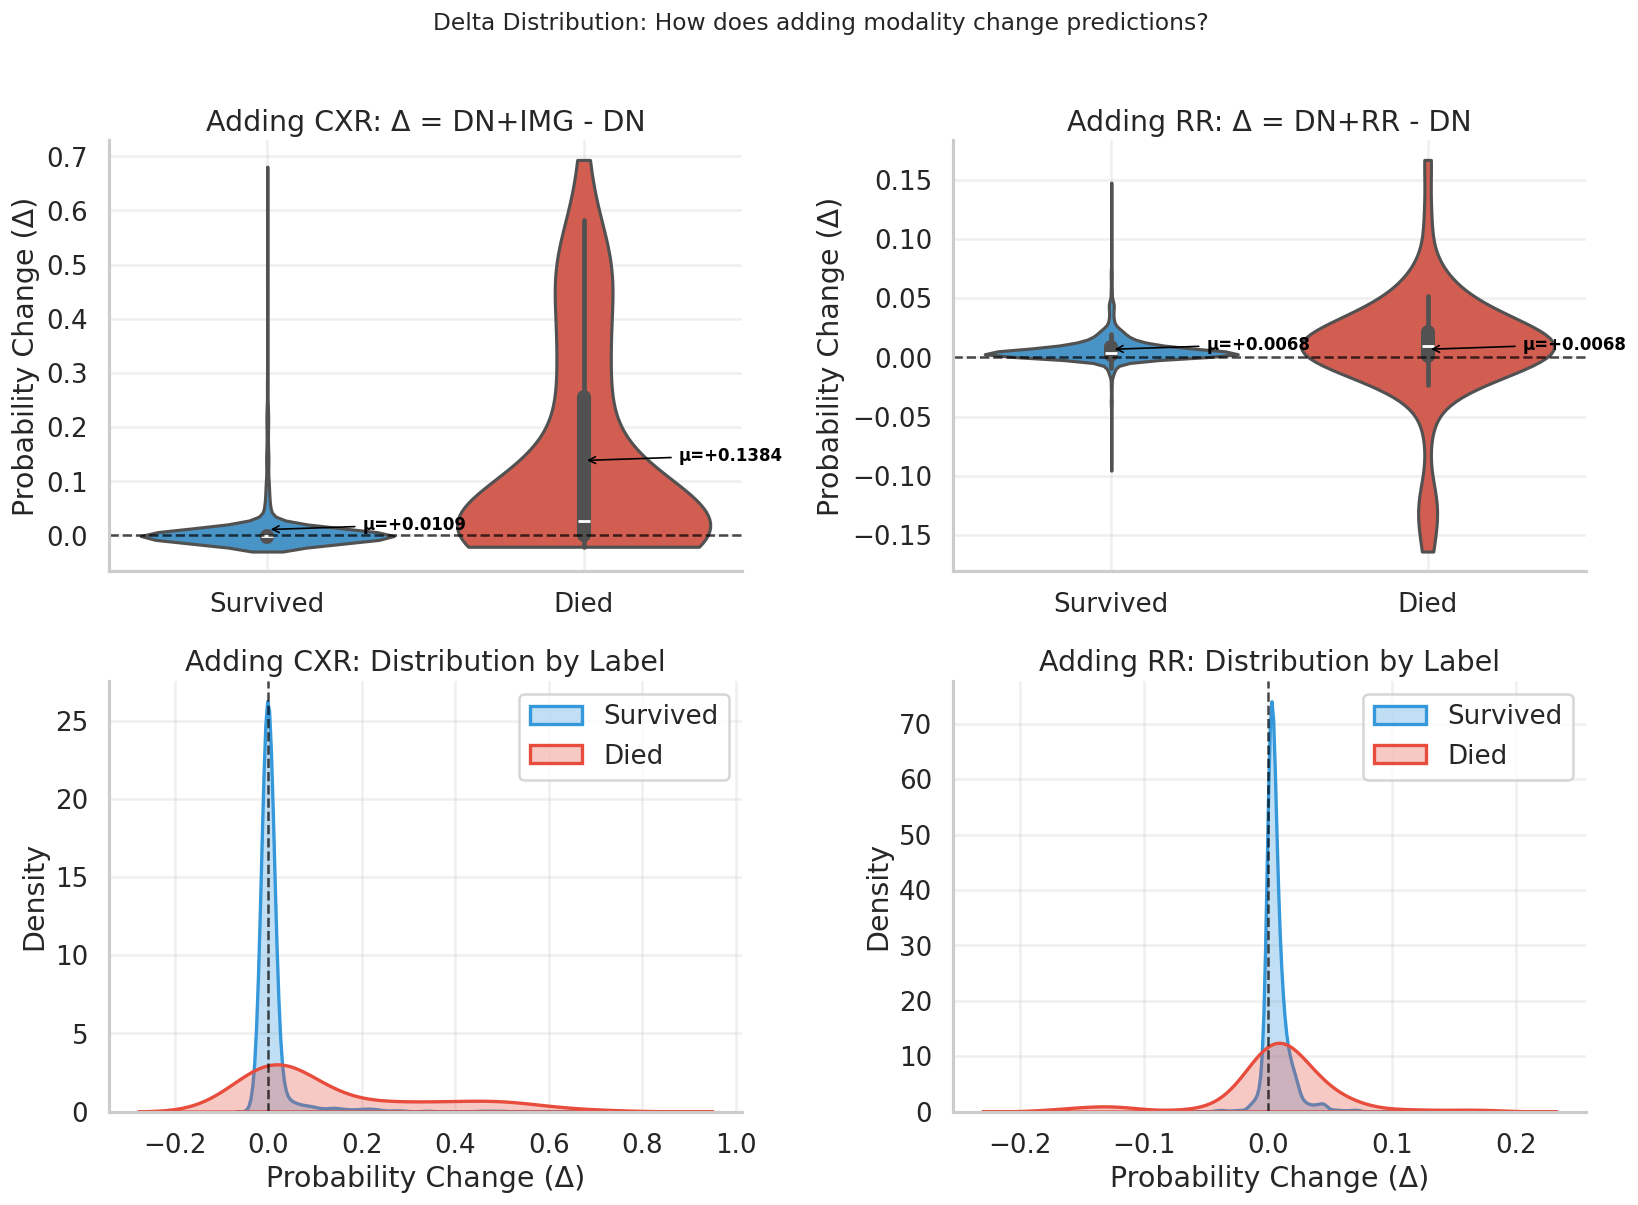

In [15]:
# Delta Distribution by Label
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

comparisons = [
    ('DN', 'DN+IMG', 'Adding CXR'),
    ('DN', 'DN+RR', 'Adding RR'),
]

for col, (base, target, title) in enumerate(comparisons):
    delta = prob_df[target] - prob_df[base]
    
    # Row 0: Violin by label
    ax = axes[0, col]
    plot_data = pd.DataFrame({
        'Delta': delta,
        'Label': prob_df['label'].map({0: 'Survived', 1: 'Died'})
    })
    sns.violinplot(data=plot_data, x='Label', y='Delta', ax=ax,
                   palette={'Survived': '#3498db', 'Died': '#e74c3c'},
                   inner='box', cut=0)
    ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_title(f'{title}: Δ = {target} - {base}')
    ax.set_ylabel('Probability Change (Δ)')
    ax.set_xlabel('')
    ax.grid(True, alpha=0.3)
    
    # Mean annotations
    for i, label in enumerate(['Survived', 'Died']):
        mask = prob_df['label'] == (1 if label == 'Died' else 0)
        mean_val = delta[mask].mean()
        ax.annotate(f'μ={mean_val:+.4f}', xy=(i, mean_val), xytext=(i+0.3, mean_val),
                    fontsize=10, color='black', fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color='black', lw=1))
    
    # Row 1: Overlapping KDE
    ax = axes[1, col]
    for label_val, label_name, color in [(0, 'Survived', '#3498db'), (1, 'Died', '#e74c3c')]:
        mask = prob_df['label'] == label_val
        sns.kdeplot(delta[mask], ax=ax, label=label_name, color=color, linewidth=2, fill=True, alpha=0.3)
    ax.axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_xlabel('Probability Change (Δ)')
    ax.set_ylabel('Density')
    ax.set_title(f'{title}: Distribution by Label')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Delta Distribution: How does adding modality change predictions?', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

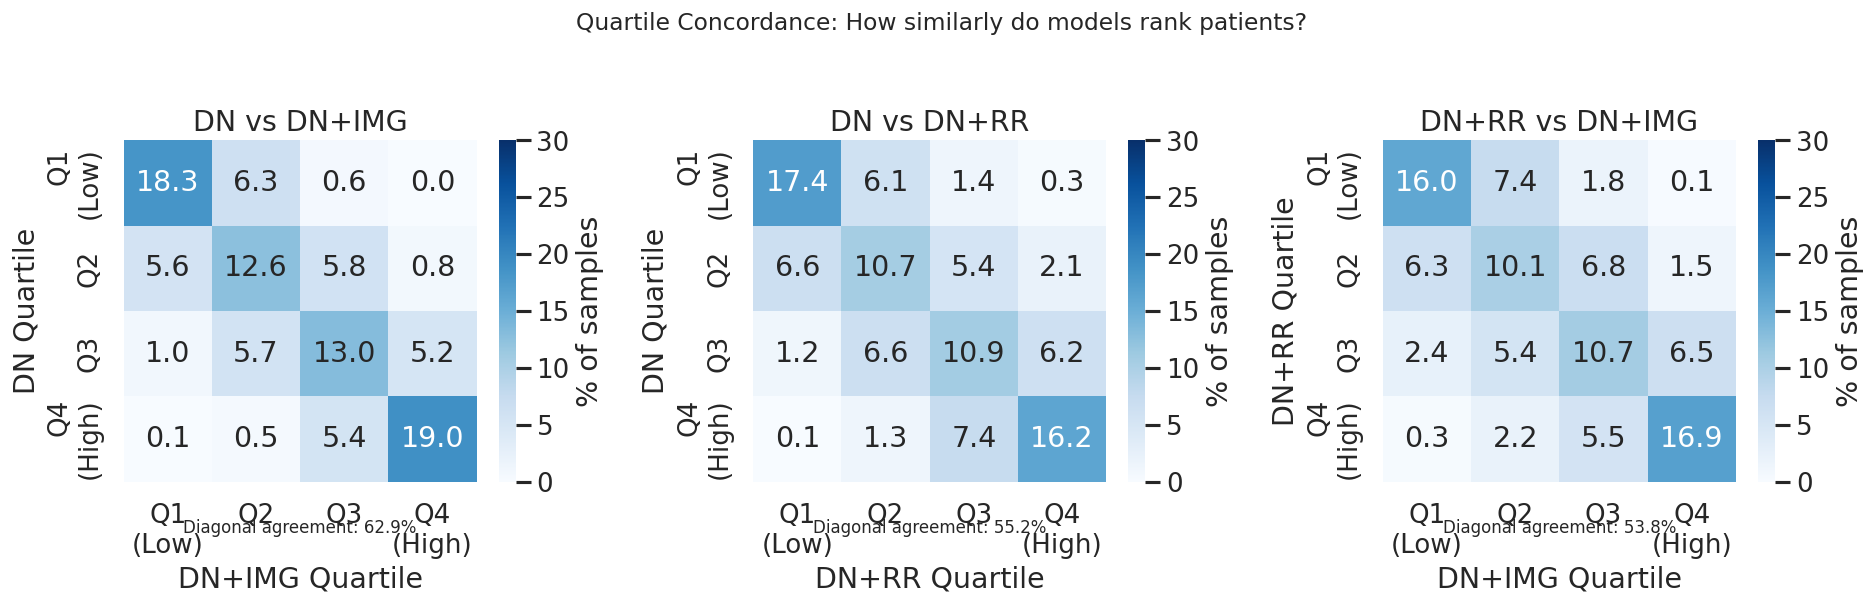

In [16]:
# Quartile Concordance Heatmap
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

model_pairs = [
    ('DN', 'DN+IMG'),
    ('DN', 'DN+RR'),
    ('DN+RR', 'DN+IMG'),
]

for ax, (m1, m2) in zip(axes, model_pairs):
    # Quartile 분류 (0~25%, 25~50%, 50~75%, 75~100%)
    q1 = pd.qcut(prob_df[m1], q=4, labels=['Q1\n(Low)', 'Q2', 'Q3', 'Q4\n(High)'])
    q2 = pd.qcut(prob_df[m2], q=4, labels=['Q1\n(Low)', 'Q2', 'Q3', 'Q4\n(High)'])
    
    # Cross-tabulation
    ct = pd.crosstab(q1, q2, normalize='all') * 100  # 전체 대비 %
    
    # Heatmap
    sns.heatmap(ct, annot=True, fmt='.1f', cmap='Blues', ax=ax, 
                cbar_kws={'label': '% of samples'}, vmin=0, vmax=30)
    ax.set_xlabel(f'{m2} Quartile')
    ax.set_ylabel(f'{m1} Quartile')
    ax.set_title(f'{m1} vs {m2}')
    
    # 대각선 일치율 계산
    diagonal_sum = sum(ct.iloc[i, i] for i in range(4))
    ax.text(0.5, -0.15, f'Diagonal agreement: {diagonal_sum:.1f}%', 
            transform=ax.transAxes, ha='center', fontsize=10)

plt.suptitle('Quartile Concordance: How similarly do models rank patients?', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## 7. Log Probability Ratio

log(p_A / p_B)로 "A가 B보다 몇 배 더 높게 예측했는지" 시각화합니다.
- 양수: A가 더 높게 예측
- 음수: B가 더 높게 예측
- log ratio = 1 → A가 B보다 ~2.7배 높음

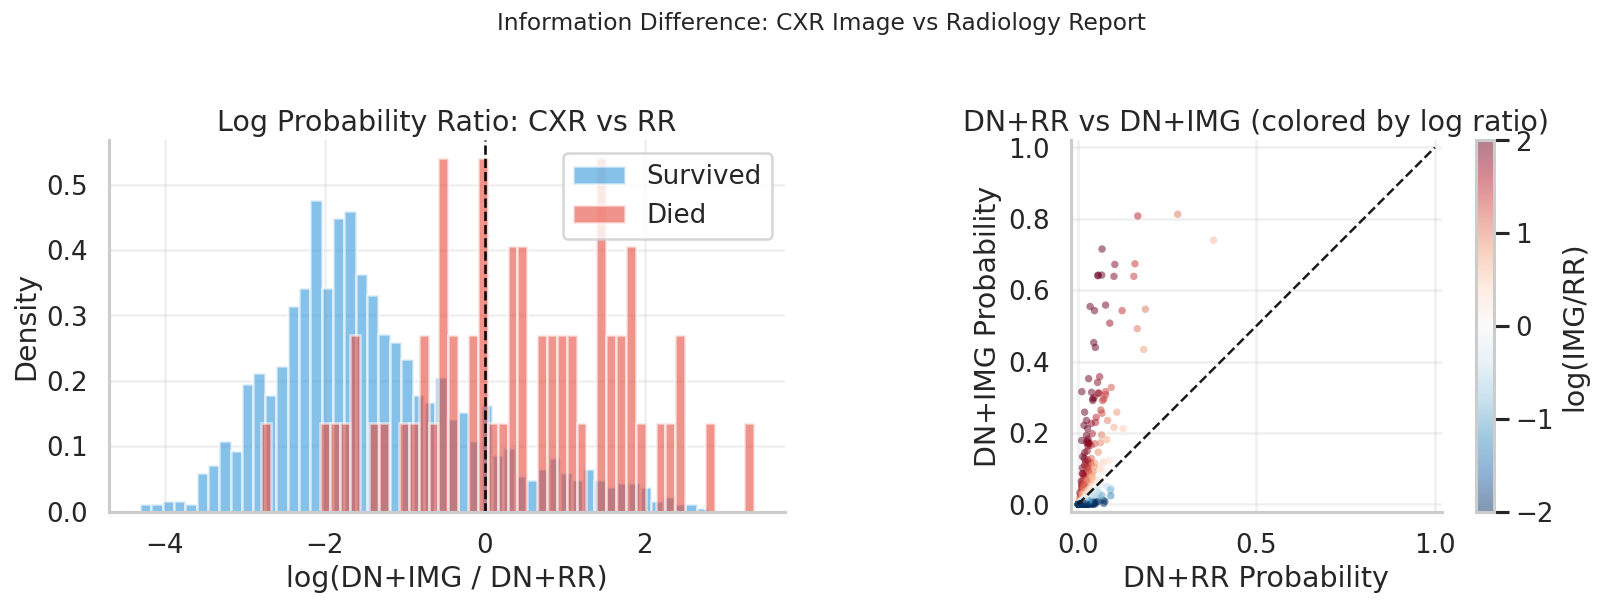


Log Ratio Statistics: log(DN+IMG / DN+RR)
Survived: mean=-1.389, std=1.250, median=-1.625
Died: mean=+0.421, std=1.332, median=+0.414


In [17]:
# Log Probability Ratio
eps = 1e-7
prob_df['log_ratio_IMG_RR'] = np.log((prob_df['DN+IMG'] + eps) / (prob_df['DN+RR'] + eps))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram by label
ax = axes[0]
for label_val, label_name, color in [(0, 'Survived', '#3498db'), (1, 'Died', '#e74c3c')]:
    mask = prob_df['label'] == label_val
    ax.hist(prob_df.loc[mask, 'log_ratio_IMG_RR'], bins=50, alpha=0.6, 
            label=label_name, color=color, density=True)
ax.axvline(0, color='black', linestyle='--', linewidth=1.5)
ax.set_xlabel('log(DN+IMG / DN+RR)')
ax.set_ylabel('Density')
ax.set_title('Log Probability Ratio: CXR vs RR')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Scatter (DN+RR vs DN+IMG) with log ratio as color
ax = axes[1]
scatter = ax.scatter(prob_df['DN+RR'], prob_df['DN+IMG'], 
                     c=prob_df['log_ratio_IMG_RR'], cmap='RdBu_r', 
                     alpha=0.5, s=20, edgecolors='none', vmin=-2, vmax=2)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
ax.set_xlabel('DN+RR Probability')
ax.set_ylabel('DN+IMG Probability')
ax.set_title('DN+RR vs DN+IMG (colored by log ratio)')
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.set_aspect('equal')
plt.colorbar(scatter, ax=ax, label='log(IMG/RR)')
ax.grid(True, alpha=0.3)

plt.suptitle('Information Difference: CXR Image vs Radiology Report', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# 통계 요약
print("\n" + "="*60)
print("Log Ratio Statistics: log(DN+IMG / DN+RR)")
print("="*60)
for label_val, label_name in [(0, 'Survived'), (1, 'Died')]:
    mask = prob_df['label'] == label_val
    vals = prob_df.loc[mask, 'log_ratio_IMG_RR']
    print(f"{label_name}: mean={vals.mean():+.3f}, std={vals.std():.3f}, "
          f"median={vals.median():+.3f}")

## 8. 종합 요약: CXR vs RR의 기여도 비교

모든 지표를 종합하여 CXR과 RR이 예측에 미치는 영향을 비교합니다.

SUMMARY: Effect of Adding Different Modalities to DN (Discharge Note)
  Modality Added  Base AUROC  Enhanced AUROC    ΔAUROC  NRI (Events)  NRI (Non-events)  NRI (Total)  Tau Distance  Events Improved %  Non-events Improved %
       CXR Image    0.832333        0.863186  0.030853      0.533333          0.514615     1.047949      0.156559           0.766667               0.756923
Radiology Report    0.832333        0.817487 -0.014846      0.566667         -0.822308    -0.255641      0.197783           0.783333               0.088462


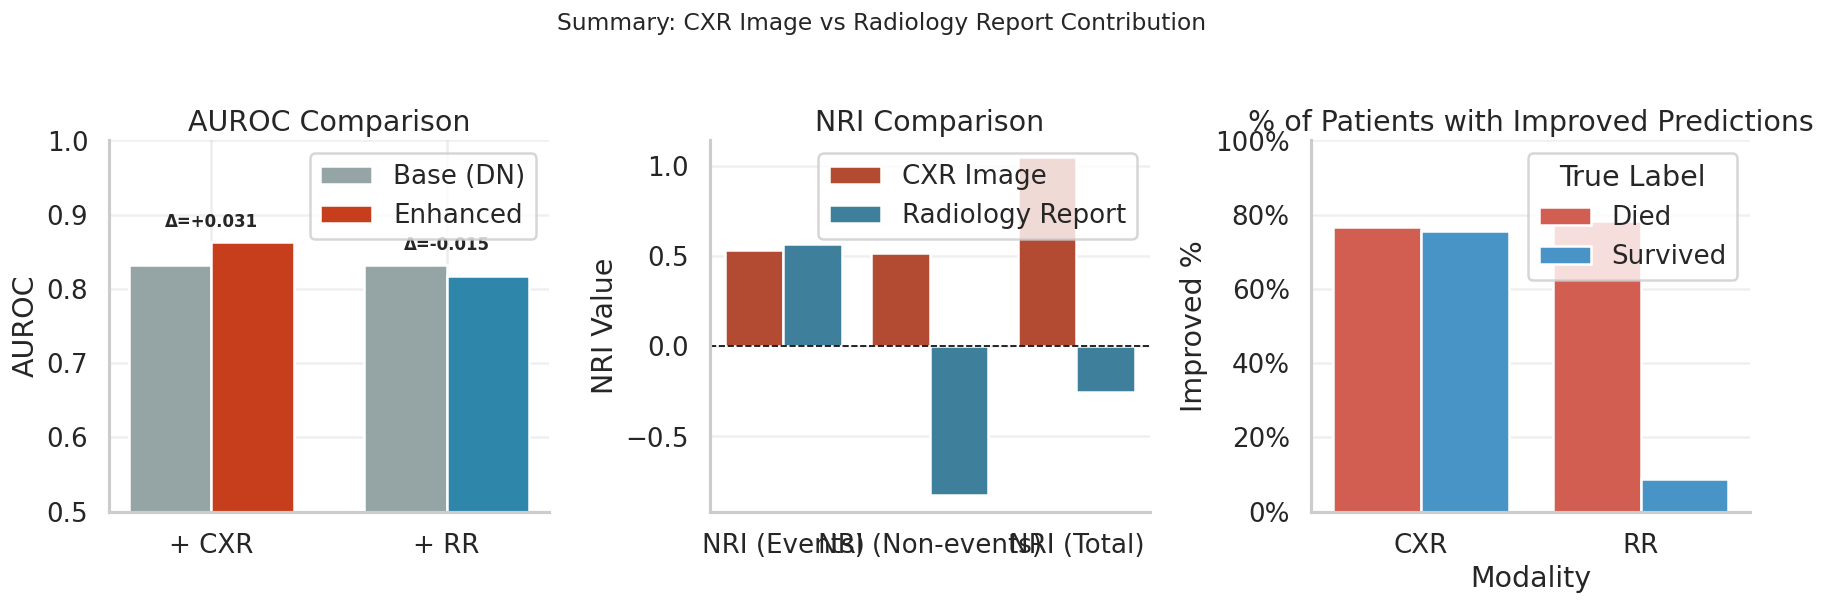

In [18]:
summary_data = []

for base, target, modality_name in [('DN', 'DN+IMG', 'CXR Image'), ('DN', 'DN+RR', 'Radiology Report')]:
    nri = compute_nri_continuous(base, target, prob_df)
    auroc_base = roc_auc_score(prob_df['label'], prob_df[base])
    auroc_target = roc_auc_score(prob_df['label'], prob_df[target])
    tau, dist, _ = kendall_tau_distance(prob_df[base], prob_df[target])
    
    summary_data.append({
        'Modality Added': modality_name,
        'Base AUROC': auroc_base,
        'Enhanced AUROC': auroc_target,
        'ΔAUROC': auroc_target - auroc_base,
        'NRI (Events)': nri['NRI_events'],
        'NRI (Non-events)': nri['NRI_non_events'],
        'NRI (Total)': nri['NRI_total'],
        'Tau Distance': dist,
        'Events Improved %': nri['events_improved'] / nri['events_total'],
        'Non-events Improved %': nri['non_events_improved'] / nri['non_events_total'],
    })

summary_df = pd.DataFrame(summary_data)

# 표 출력
print("=" * 100)
print("SUMMARY: Effect of Adding Different Modalities to DN (Discharge Note)")
print("=" * 100)
print(summary_df.to_string(index=False))

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. AUROC comparison
ax = axes[0]
x = np.arange(2)
width = 0.35
bars1 = ax.bar(x - width/2, [summary_df.iloc[i]['Base AUROC'] for i in range(2)], width, label='Base (DN)', color='#95a5a6')
bars2 = ax.bar(x + width/2, [summary_df.iloc[i]['Enhanced AUROC'] for i in range(2)], width, label='Enhanced', color=['#C73E1D', '#2E86AB'])
ax.set_ylabel('AUROC')
ax.set_title('AUROC Comparison')
ax.set_xticks(x)
ax.set_xticklabels(['+ CXR', '+ RR'])
ax.legend()
ax.set_ylim(0.5, 1.0)
ax.grid(True, axis='y', alpha=0.3)

# Annotate ΔAUROC
for i, (b1, b2) in enumerate(zip(bars1, bars2)):
    delta = summary_df.iloc[i]['ΔAUROC']
    ax.annotate(f'Δ={delta:+.3f}', xy=(x[i], max(b1.get_height(), b2.get_height()) + 0.02),
                ha='center', fontsize=10, fontweight='bold')

# 2. NRI comparison
ax = axes[1]
nri_data = summary_df[['Modality Added', 'NRI (Events)', 'NRI (Non-events)', 'NRI (Total)']].melt(
    id_vars='Modality Added', var_name='NRI Type', value_name='NRI Value')
sns.barplot(data=nri_data, x='NRI Type', y='NRI Value', hue='Modality Added', ax=ax,
            palette={'CXR Image': '#C73E1D', 'Radiology Report': '#2E86AB'})
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_title('NRI Comparison')
ax.set_xlabel('')
ax.legend(title='')
ax.grid(True, axis='y', alpha=0.3)

# 3. Improved % comparison
ax = axes[2]
improved_data = pd.DataFrame({
    'Modality': ['CXR', 'CXR', 'RR', 'RR'],
    'Group': ['Died', 'Survived', 'Died', 'Survived'],
    'Improved %': [summary_df.iloc[0]['Events Improved %'], summary_df.iloc[0]['Non-events Improved %'],
                   summary_df.iloc[1]['Events Improved %'], summary_df.iloc[1]['Non-events Improved %']]
})
sns.barplot(data=improved_data, x='Modality', y='Improved %', hue='Group', ax=ax,
            palette={'Died': '#e74c3c', 'Survived': '#3498db'})
ax.set_title('% of Patients with Improved Predictions')
ax.set_ylabel('Improved %')
ax.set_ylim(0, 1)
ax.legend(title='True Label')
ax.grid(True, axis='y', alpha=0.3)

# y축을 %로 표시
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.suptitle('Summary: CXR Image vs Radiology Report Contribution', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## 9. Rank 기반 정성평가 (Precision@K)

확률이 0 근처여도 **랭킹**은 의미 있음.

### A. Precision@K
상위 K명 안에 실제 사망자(true=1)가 몇 명 들어있는지 확인.
- K = 50, 100, 200 등
- AUPRC보다 직관적이고 임상의와 커뮤니케이션이 쉬움

### B. 사망자(true=1)의 Percentile Rank 비교
- 모델 A에서의 percentile rank vs 모델 B에서의 percentile rank
- "모델 B가 사망 환자를 더 상위로 끌어올린다"를 확률 캘리브레이션 없이 확인

In [19]:
# ============================================================
# A. Precision@K: 상위 K명 중 실제 사망자 수
# ============================================================

def precision_at_k(scores: pd.Series, labels: pd.Series, k: int) -> dict:
    """Compute precision at K: how many true=1 in top K by score."""
    # 내림차순 정렬 (높은 확률이 상위)
    sorted_idx = scores.sort_values(ascending=False).index[:k]
    top_k_labels = labels.loc[sorted_idx]
    
    n_positive_in_top_k = top_k_labels.sum()
    precision = n_positive_in_top_k / k
    
    # 전체 사망자 중 몇 %가 상위 K에 있는지 (Recall@K)
    total_positives = labels.sum()
    recall = n_positive_in_top_k / total_positives if total_positives > 0 else 0
    
    return {
        'k': k,
        'n_positive_in_top_k': int(n_positive_in_top_k),
        'precision': precision,
        'recall': recall,
    }

# 각 모델에 대해 Precision@K 계산
k_values = [50, 100, 200, 300, 500]
models = ['DN', 'DN+RR', 'DN+IMG']

precision_results = []
for m in models:
    for k in k_values:
        result = precision_at_k(prob_df[m], prob_df['label'], k)
        result['model'] = m
        precision_results.append(result)

precision_df = pd.DataFrame(precision_results)

# 표 형식으로 피벗
pivot_precision = precision_df.pivot(index='k', columns='model', values='n_positive_in_top_k')[models]
pivot_recall = precision_df.pivot(index='k', columns='model', values='recall')[models]

print("=" * 70)
print("Precision@K: Number of True Positives in Top K")
print("=" * 70)
print(pivot_precision.to_string())
print(f"\n(Total positives in dataset: {int(prob_df['label'].sum())})")

print("\n" + "=" * 70)
print("Recall@K: % of All Positives Captured in Top K")
print("=" * 70)
print((pivot_recall * 100).round(1).astype(str) + '%')

Precision@K: Number of True Positives in Top K
model  DN  DN+RR  DN+IMG
k                       
50     17     18      18
100    26     27      27
200    34     36      43
300    42     40      47
500    51     50      51

(Total positives in dataset: 60)

Recall@K: % of All Positives Captured in Top K
model     DN  DN+RR DN+IMG
k                         
50     28.3%  30.0%  30.0%
100    43.3%  45.0%  45.0%
200    56.7%  60.0%  71.7%
300    70.0%  66.7%  78.3%
500    85.0%  83.3%  85.0%


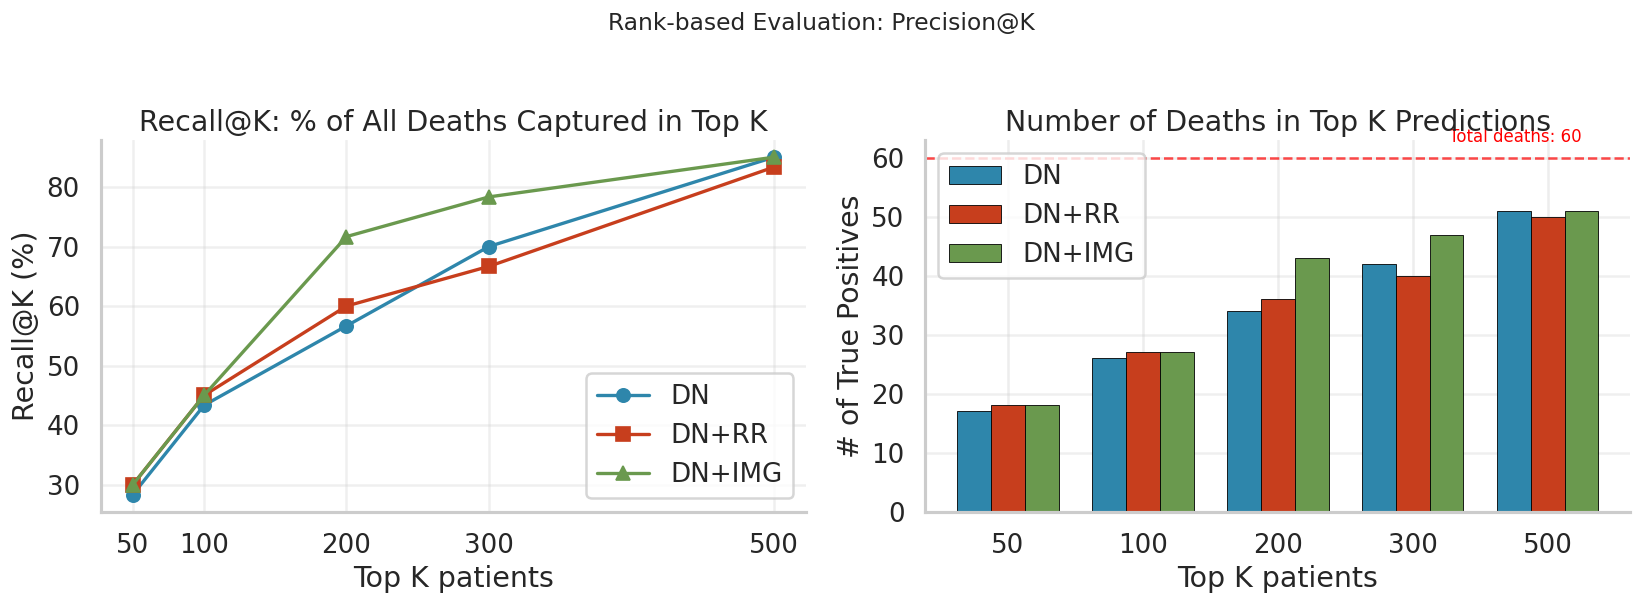

In [20]:
# Precision@K / Recall@K 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_colors = {'DN': '#2E86AB', 'DN+RR': '#C73E1D', 'DN+IMG': '#6A994E'}
model_markers = {'DN': 'o', 'DN+RR': 's', 'DN+IMG': '^'}

# Left: Recall@K (더 직관적)
ax = axes[0]
for m in models:
    model_data = precision_df[precision_df['model'] == m]
    ax.plot(model_data['k'], model_data['recall'] * 100, 
            marker=model_markers[m], markersize=8, linewidth=2,
            color=model_colors[m], label=m)
ax.set_xlabel('Top K patients')
ax.set_ylabel('Recall@K (%)')
ax.set_title('Recall@K: % of All Deaths Captured in Top K')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(k_values)

# Right: Number of true positives in top K
ax = axes[1]
x = np.arange(len(k_values))
width = 0.25

for i, m in enumerate(models):
    model_data = precision_df[precision_df['model'] == m].sort_values('k')
    ax.bar(x + i * width, model_data['n_positive_in_top_k'], width, 
           label=m, color=model_colors[m], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Top K patients')
ax.set_ylabel('# of True Positives')
ax.set_title('Number of Deaths in Top K Predictions')
ax.set_xticks(x + width)
ax.set_xticklabels(k_values)
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

# Annotate total positives
total_pos = int(prob_df['label'].sum())
ax.axhline(total_pos, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax.text(len(k_values) - 0.5, total_pos + 2, f'Total deaths: {total_pos}', 
        ha='right', va='bottom', color='red', fontsize=10)

plt.suptitle('Rank-based Evaluation: Precision@K', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### B. 사망자(true=1)의 Percentile Rank 비교

각 사망 환자가 모델별로 몇 번째 순위(percentile)에 있는지 비교합니다.
- Percentile 100% = 가장 높은 위험 예측 (상위 1%)
- Percentile 0% = 가장 낮은 위험 예측 (하위 1%)

**좋은 모델**: 사망 환자들의 percentile이 높을수록 좋음 (상위에 위치)

In [21]:
# ============================================================
# B. 사망자(true=1)의 Percentile Rank 비교
# ============================================================

# 각 모델에서의 percentile rank 계산 (높을수록 상위 = 고위험 예측)
for m in models:
    prob_df[f'{m}_pct'] = prob_df[m].rank(pct=True) * 100  # 0-100%

# 사망자만 추출
died_df = prob_df[prob_df['label'] == 1].copy()

print(f"Total deaths: {len(died_df)}")
print("\nPercentile Rank Statistics for Deaths:")
print("-" * 50)
for m in models:
    pct_col = f'{m}_pct'
    print(f"{m}:")
    print(f"  Mean: {died_df[pct_col].mean():.1f}%")
    print(f"  Median: {died_df[pct_col].median():.1f}%")
    print(f"  % in Top 25%: {(died_df[pct_col] >= 75).mean():.1%}")
    print(f"  % in Top 10%: {(died_df[pct_col] >= 90).mean():.1%}")

Total deaths: 60

Percentile Rank Statistics for Deaths:
--------------------------------------------------
DN:
  Mean: 81.8%
  Median: 89.5%
  % in Top 25%: 75.0%
  % in Top 10%: 50.0%
DN+RR:
  Mean: 80.4%
  Median: 89.0%
  % in Top 25%: 75.0%
  % in Top 10%: 48.3%
DN+IMG:
  Mean: 84.8%
  Median: 90.8%
  % in Top 25%: 80.0%
  % in Top 10%: 51.7%


/tmp/ipykernel_2088379/1182251987.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pct_data, x='Model', y='Percentile', ax=ax,


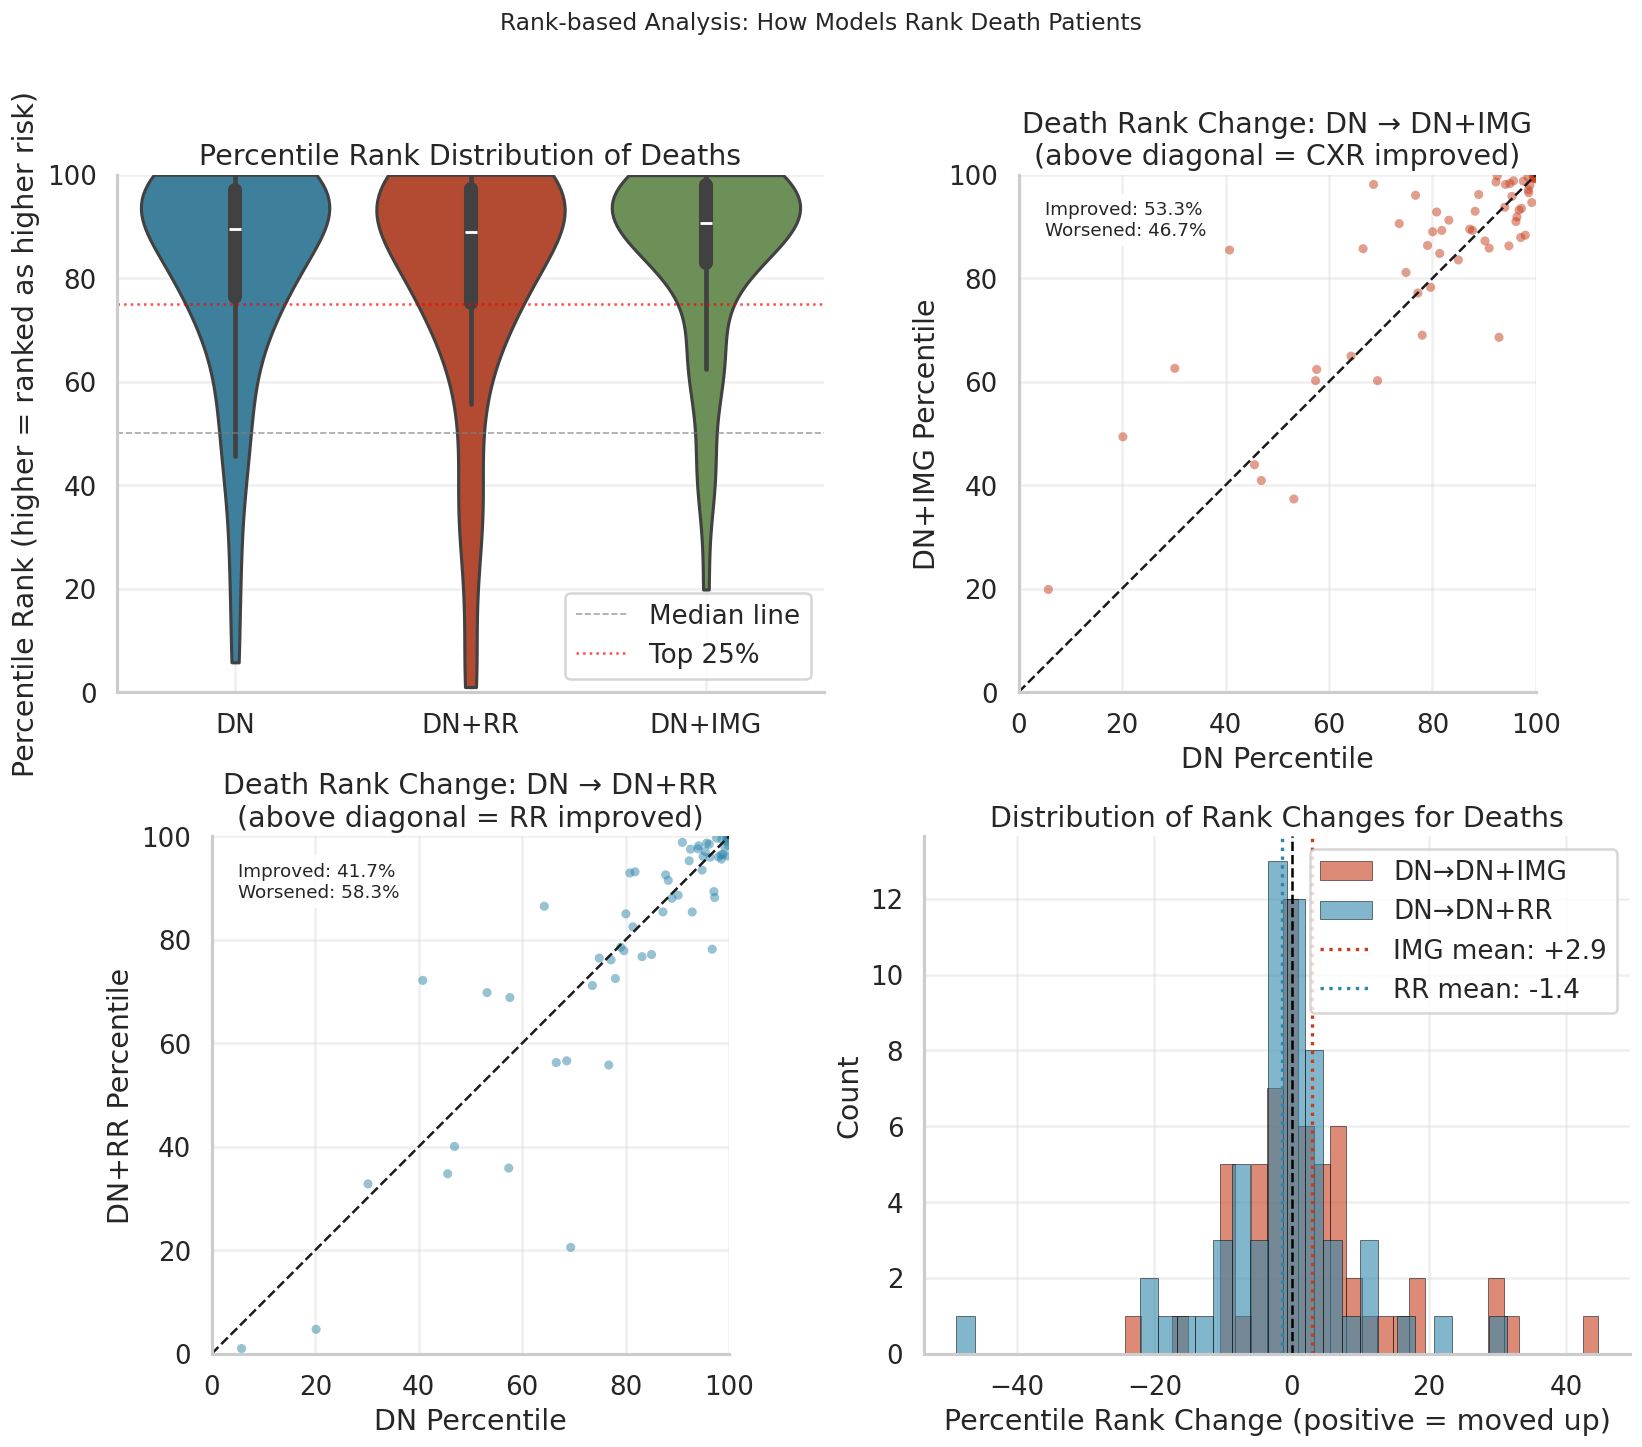

In [22]:
# 사망자 Percentile Rank 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Violin plot: 사망자의 percentile 분포
ax = axes[0, 0]
pct_data = pd.melt(died_df[[f'{m}_pct' for m in models]], 
                   var_name='Model', value_name='Percentile')
pct_data['Model'] = pct_data['Model'].str.replace('_pct', '')
sns.violinplot(data=pct_data, x='Model', y='Percentile', ax=ax,
               palette=model_colors, inner='box', cut=0, order=models)
ax.axhline(50, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Median line')
ax.axhline(75, color='red', linestyle=':', linewidth=1.5, alpha=0.7, label='Top 25%')
ax.set_title('Percentile Rank Distribution of Deaths')
ax.set_ylabel('Percentile Rank (higher = ranked as higher risk)')
ax.set_xlabel('')
ax.set_ylim(0, 100)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# 2. Scatter: DN vs DN+IMG percentile 비교
ax = axes[0, 1]
ax.scatter(died_df['DN_pct'], died_df['DN+IMG_pct'], alpha=0.5, s=30, c='#C73E1D', edgecolors='none')
ax.plot([0, 100], [0, 100], 'k--', linewidth=1.5, label='No change')
ax.set_xlabel('DN Percentile')
ax.set_ylabel('DN+IMG Percentile')
ax.set_title('Death Rank Change: DN → DN+IMG\n(above diagonal = CXR improved)')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# 통계 표시
improved = (died_df['DN+IMG_pct'] > died_df['DN_pct']).mean()
ax.text(0.05, 0.95, f'Improved: {improved:.1%}\nWorsened: {1-improved:.1%}', 
        transform=ax.transAxes, fontsize=11, va='top', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Scatter: DN vs DN+RR percentile 비교
ax = axes[1, 0]
ax.scatter(died_df['DN_pct'], died_df['DN+RR_pct'], alpha=0.5, s=30, c='#2E86AB', edgecolors='none')
ax.plot([0, 100], [0, 100], 'k--', linewidth=1.5, label='No change')
ax.set_xlabel('DN Percentile')
ax.set_ylabel('DN+RR Percentile')
ax.set_title('Death Rank Change: DN → DN+RR\n(above diagonal = RR improved)')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

improved_rr = (died_df['DN+RR_pct'] > died_df['DN_pct']).mean()
ax.text(0.05, 0.95, f'Improved: {improved_rr:.1%}\nWorsened: {1-improved_rr:.1%}', 
        transform=ax.transAxes, fontsize=11, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Histogram: Percentile rank 변화량
ax = axes[1, 1]
delta_img = died_df['DN+IMG_pct'] - died_df['DN_pct']
delta_rr = died_df['DN+RR_pct'] - died_df['DN_pct']

ax.hist(delta_img, bins=30, alpha=0.6, label='DN→DN+IMG', color='#C73E1D', edgecolor='black', linewidth=0.5)
ax.hist(delta_rr, bins=30, alpha=0.6, label='DN→DN+RR', color='#2E86AB', edgecolor='black', linewidth=0.5)
ax.axvline(0, color='black', linestyle='--', linewidth=1.5)
ax.axvline(delta_img.mean(), color='#C73E1D', linestyle=':', linewidth=2, label=f'IMG mean: {delta_img.mean():+.1f}')
ax.axvline(delta_rr.mean(), color='#2E86AB', linestyle=':', linewidth=2, label=f'RR mean: {delta_rr.mean():+.1f}')
ax.set_xlabel('Percentile Rank Change (positive = moved up)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Rank Changes for Deaths')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.suptitle('Rank-based Analysis: How Models Rank Death Patients', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

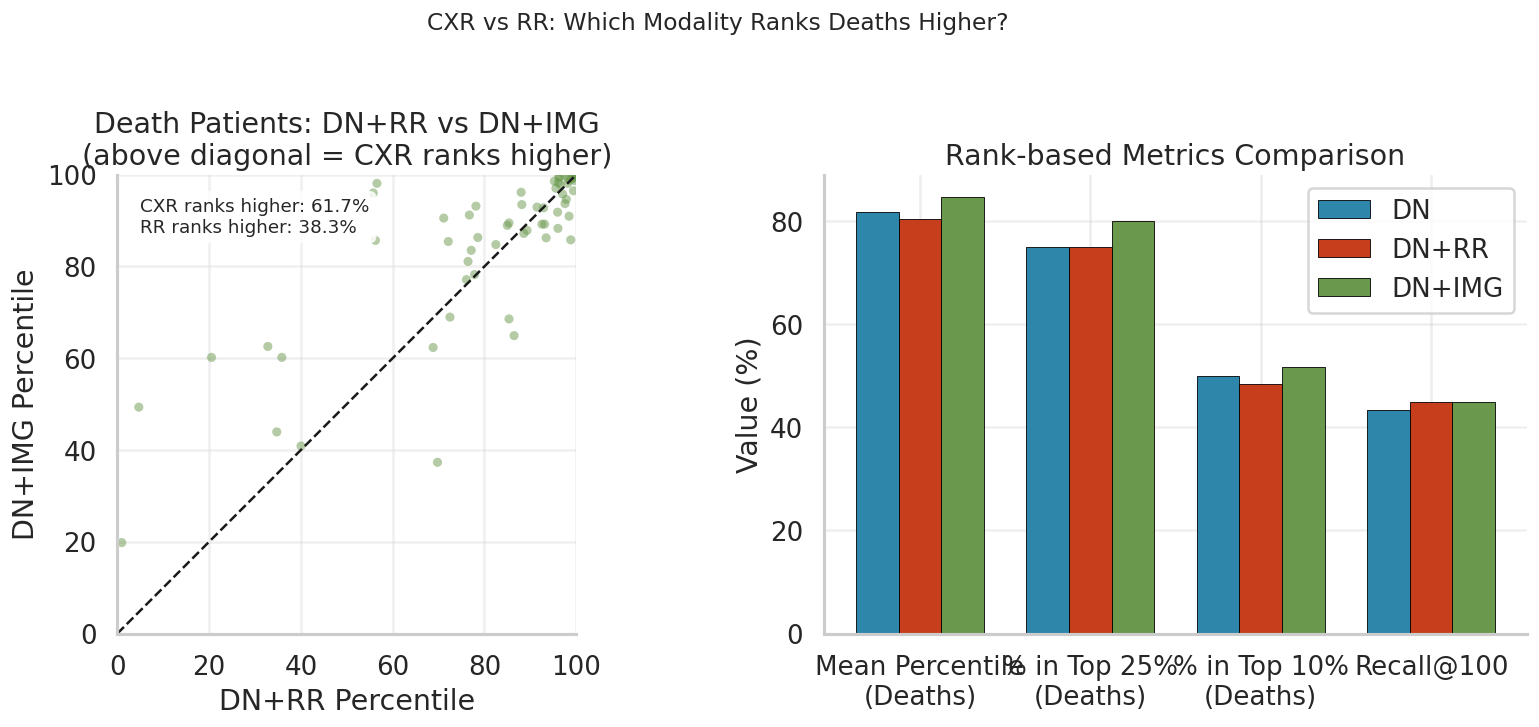


SUMMARY: Rank-based Comparison (CXR vs RR)
For DEATH patients:
  - DN+IMG ranks higher than DN+RR: 61.7% of cases
  - DN+RR ranks higher than DN+IMG: 38.3% of cases

Mean percentile rank for deaths:
  - DN:      81.8%
  - DN+RR:   80.4%
  - DN+IMG:  84.8%


In [23]:
# CXR vs RR 직접 비교: 사망 환자의 순위 변화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Scatter: DN+RR vs DN+IMG percentile (사망자만)
ax = axes[0]
ax.scatter(died_df['DN+RR_pct'], died_df['DN+IMG_pct'], alpha=0.5, s=30, c='#6A994E', edgecolors='none')
ax.plot([0, 100], [0, 100], 'k--', linewidth=1.5)
ax.set_xlabel('DN+RR Percentile')
ax.set_ylabel('DN+IMG Percentile')
ax.set_title('Death Patients: DN+RR vs DN+IMG\n(above diagonal = CXR ranks higher)')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

img_better = (died_df['DN+IMG_pct'] > died_df['DN+RR_pct']).mean()
ax.text(0.05, 0.95, f'CXR ranks higher: {img_better:.1%}\nRR ranks higher: {1-img_better:.1%}', 
        transform=ax.transAxes, fontsize=11, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. 요약 비교 bar chart
ax = axes[1]
comparison_data = {
    'Metric': ['Mean Percentile\n(Deaths)', '% in Top 25%\n(Deaths)', '% in Top 10%\n(Deaths)', 'Recall@100'],
    'DN': [
        died_df['DN_pct'].mean(),
        (died_df['DN_pct'] >= 75).mean() * 100,
        (died_df['DN_pct'] >= 90).mean() * 100,
        precision_df[(precision_df['model'] == 'DN') & (precision_df['k'] == 100)]['recall'].values[0] * 100,
    ],
    'DN+RR': [
        died_df['DN+RR_pct'].mean(),
        (died_df['DN+RR_pct'] >= 75).mean() * 100,
        (died_df['DN+RR_pct'] >= 90).mean() * 100,
        precision_df[(precision_df['model'] == 'DN+RR') & (precision_df['k'] == 100)]['recall'].values[0] * 100,
    ],
    'DN+IMG': [
        died_df['DN+IMG_pct'].mean(),
        (died_df['DN+IMG_pct'] >= 75).mean() * 100,
        (died_df['DN+IMG_pct'] >= 90).mean() * 100,
        precision_df[(precision_df['model'] == 'DN+IMG') & (precision_df['k'] == 100)]['recall'].values[0] * 100,
    ],
}

x = np.arange(len(comparison_data['Metric']))
width = 0.25

for i, m in enumerate(models):
    ax.bar(x + i * width, comparison_data[m], width, label=m, color=model_colors[m], 
           edgecolor='black', linewidth=0.5)

ax.set_ylabel('Value (%)')
ax.set_title('Rank-based Metrics Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(comparison_data['Metric'])
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.suptitle('CXR vs RR: Which Modality Ranks Deaths Higher?', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# 최종 요약 출력
print("\n" + "=" * 70)
print("SUMMARY: Rank-based Comparison (CXR vs RR)")
print("=" * 70)
print(f"For DEATH patients:")
print(f"  - DN+IMG ranks higher than DN+RR: {img_better:.1%} of cases")
print(f"  - DN+RR ranks higher than DN+IMG: {1-img_better:.1%} of cases")
print(f"\nMean percentile rank for deaths:")
print(f"  - DN:      {died_df['DN_pct'].mean():.1f}%")
print(f"  - DN+RR:   {died_df['DN+RR_pct'].mean():.1f}%")
print(f"  - DN+IMG:  {died_df['DN+IMG_pct'].mean():.1f}%")

## 10. Permutation Test: Mean Percentile Rank (DN+RR vs DN+IMG)

**Null Hypothesis**: DN+RR과 DN+IMG의 사망자 평균 순위에 차이가 없다.

**방법**: 각 사망 환자에 대해 DN+RR과 DN+IMG의 percentile을 무작위로 swap → 1000번 반복 → null distribution 생성 → 실제 관측값의 p-value 계산

In [24]:
# ============================================================
# Permutation Test: Mean Percentile Rank (DN+RR vs DN+IMG)
# ============================================================

def permutation_test_mean_percentile(
    pct_a: np.ndarray, 
    pct_b: np.ndarray, 
    n_permutations: int = 10000,
    seed: int = 42
) -> dict:
    """
    Paired permutation test for mean percentile difference.
    
    H0: mean(pct_a) = mean(pct_b)
    H1: mean(pct_a) ≠ mean(pct_b) (two-sided)
    
    For each sample, randomly swap pct_a and pct_b with 50% probability.
    """
    np.random.seed(seed)
    
    n = len(pct_a)
    assert len(pct_b) == n, "Arrays must have same length"
    
    # Observed statistic: mean(B) - mean(A)
    # 양수 = B(DN+IMG)가 더 높음
    observed_diff = pct_b.mean() - pct_a.mean()
    
    # Permutation distribution
    perm_diffs = np.zeros(n_permutations)
    
    for i in range(n_permutations):
        # 각 샘플에 대해 50% 확률로 swap
        swap_mask = np.random.rand(n) < 0.5
        
        perm_a = np.where(swap_mask, pct_b, pct_a)
        perm_b = np.where(swap_mask, pct_a, pct_b)
        
        perm_diffs[i] = perm_b.mean() - perm_a.mean()
    
    # Two-sided p-value
    p_value = (np.abs(perm_diffs) >= np.abs(observed_diff)).mean()
    
    # One-sided p-values
    p_value_greater = (perm_diffs >= observed_diff).mean()  # B > A
    p_value_less = (perm_diffs <= observed_diff).mean()     # B < A
    
    return {
        'observed_diff': observed_diff,
        'perm_diffs': perm_diffs,
        'p_value_twosided': p_value,
        'p_value_greater': p_value_greater,
        'p_value_less': p_value_less,
        'n_permutations': n_permutations,
        'n_samples': n,
    }

# 사망자에 대해 테스트
pct_rr = died_df['DN+RR_pct'].values
pct_img = died_df['DN+IMG_pct'].values

print("Running permutation test (10,000 iterations)...")
result = permutation_test_mean_percentile(pct_rr, pct_img, n_permutations=10000)

print("\n" + "=" * 70)
print("Permutation Test: Mean Percentile Rank of Deaths")
print("Comparing DN+RR vs DN+IMG")
print("=" * 70)
print(f"\nSample size (deaths): {result['n_samples']}")
print(f"Mean percentile (DN+RR):  {pct_rr.mean():.2f}%")
print(f"Mean percentile (DN+IMG): {pct_img.mean():.2f}%")
print(f"\nObserved difference (IMG - RR): {result['observed_diff']:+.2f}%")
print(f"\nP-values:")
print(f"  Two-sided (H1: IMG ≠ RR): p = {result['p_value_twosided']:.4f}")
print(f"  One-sided (H1: IMG > RR): p = {result['p_value_greater']:.4f}")
print(f"  One-sided (H1: IMG < RR): p = {result['p_value_less']:.4f}")

if result['p_value_twosided'] < 0.05:
    print(f"\n✓ Statistically significant at α=0.05")
else:
    print(f"\n✗ Not statistically significant at α=0.05")

Running permutation test (10,000 iterations)...

Permutation Test: Mean Percentile Rank of Deaths
Comparing DN+RR vs DN+IMG

Sample size (deaths): 60
Mean percentile (DN+RR):  80.38%
Mean percentile (DN+IMG): 84.75%

Observed difference (IMG - RR): +4.37%

P-values:
  Two-sided (H1: IMG ≠ RR): p = 0.0196
  One-sided (H1: IMG > RR): p = 0.0104
  One-sided (H1: IMG < RR): p = 0.9898

✓ Statistically significant at α=0.05


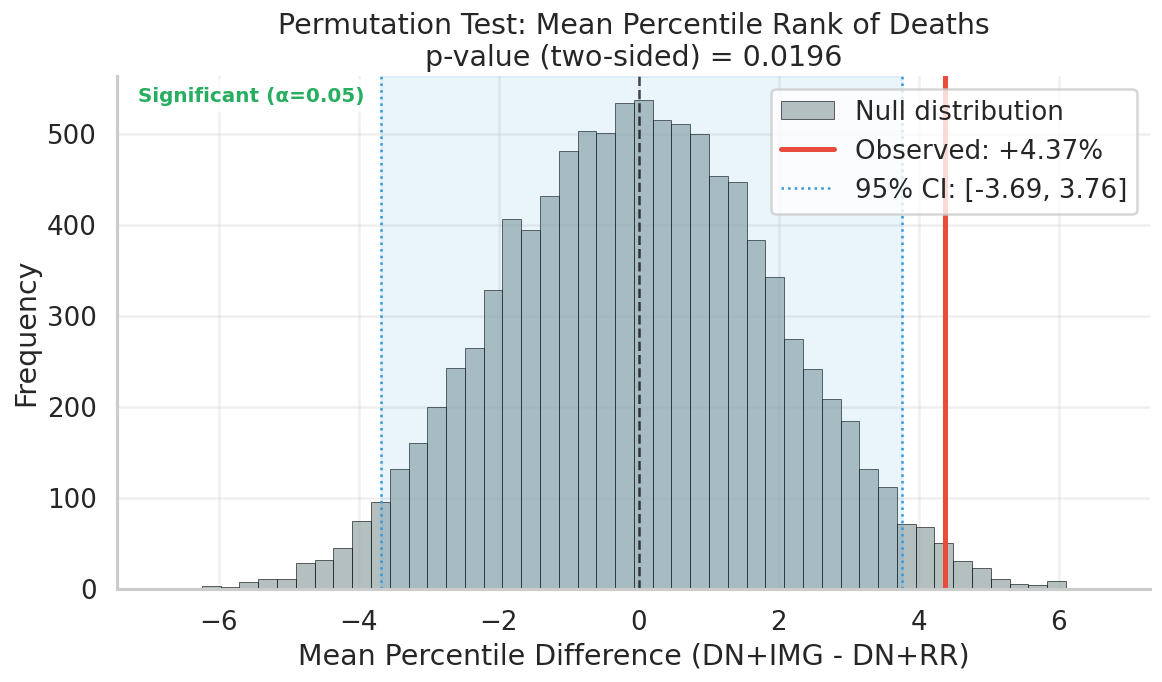

In [25]:
# Permutation Test 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# Null distribution histogram
ax.hist(result['perm_diffs'], bins=50, alpha=0.7, color='#95a5a6', 
        edgecolor='black', linewidth=0.5, label='Null distribution')

# Observed value
ax.axvline(result['observed_diff'], color='#e74c3c', linewidth=3, 
           linestyle='-', label=f'Observed: {result["observed_diff"]:+.2f}%')

# Zero line
ax.axvline(0, color='black', linewidth=1.5, linestyle='--', alpha=0.7)

# Critical regions (if significant)
if result['p_value_twosided'] < 0.05:
    # 95% CI of null distribution
    lower = np.percentile(result['perm_diffs'], 2.5)
    upper = np.percentile(result['perm_diffs'], 97.5)
    ax.axvline(lower, color='#3498db', linewidth=1.5, linestyle=':', label=f'95% CI: [{lower:.2f}, {upper:.2f}]')
    ax.axvline(upper, color='#3498db', linewidth=1.5, linestyle=':')
    ax.axvspan(lower, upper, alpha=0.1, color='#3498db')

ax.set_xlabel('Mean Percentile Difference (DN+IMG - DN+RR)')
ax.set_ylabel('Frequency')
ax.set_title(f'Permutation Test: Mean Percentile Rank of Deaths\n'
             f'p-value (two-sided) = {result["p_value_twosided"]:.4f}')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# 유의성 표시
significance = "Significant" if result['p_value_twosided'] < 0.05 else "Not Significant"
color = '#27ae60' if result['p_value_twosided'] < 0.05 else '#e74c3c'
ax.text(0.02, 0.98, f'{significance} (α=0.05)', transform=ax.transAxes, 
        fontsize=12, va='top', fontweight='bold', color=color,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Permutation Tests: All Pairwise Comparisons (Mean Percentile of Deaths)
     Comparison    Mean A    Mean B  Diff (B-A)  p-value (two-sided) Significant (α=0.05)
   DN vs DN+IMG 81.803922 84.753064    2.949142               0.0489                    ✓
    DN vs DN+RR 81.803922 80.384804   -1.419118               0.3287                    ✗
DN+RR vs DN+IMG 80.384804 84.753064    4.368260               0.0196                    ✓


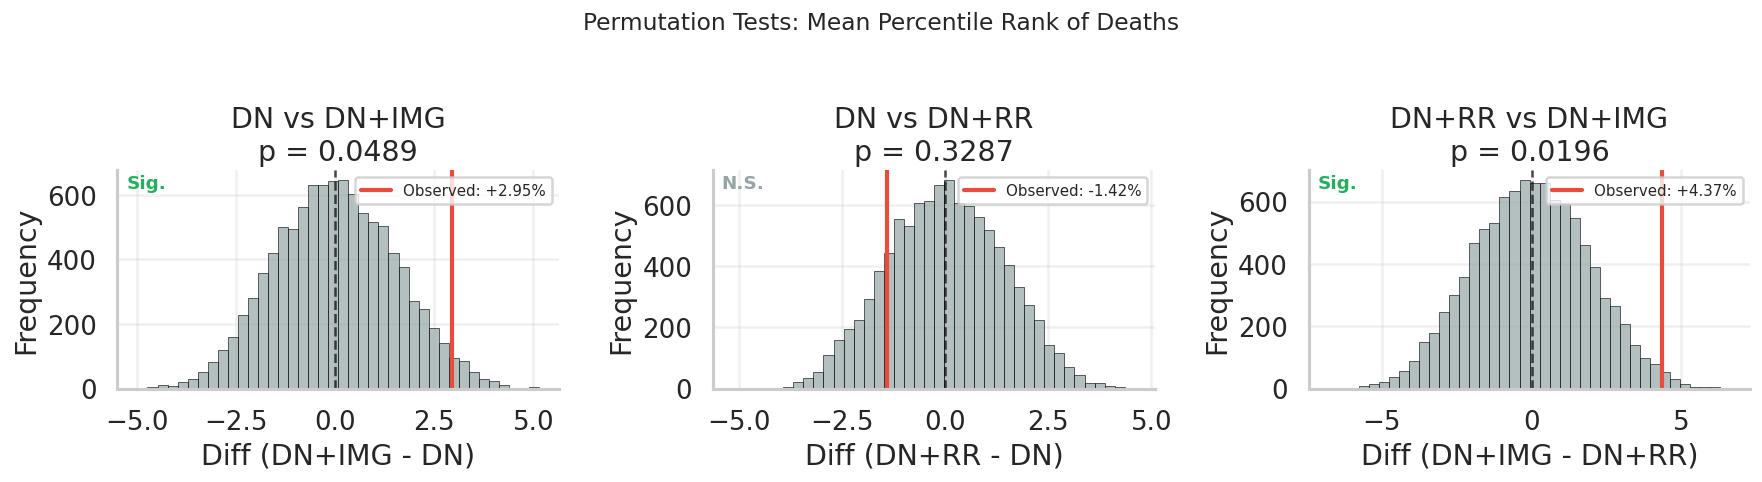

In [26]:
# 추가 비교: DN vs DN+IMG, DN vs DN+RR
pct_dn = died_df['DN_pct'].values

comparisons = [
    ('DN', 'DN+IMG', pct_dn, pct_img),
    ('DN', 'DN+RR', pct_dn, pct_rr),
    ('DN+RR', 'DN+IMG', pct_rr, pct_img),
]

print("=" * 80)
print("Permutation Tests: All Pairwise Comparisons (Mean Percentile of Deaths)")
print("=" * 80)

all_results = []
for name_a, name_b, arr_a, arr_b in comparisons:
    res = permutation_test_mean_percentile(arr_a, arr_b, n_permutations=10000)
    all_results.append({
        'Comparison': f'{name_a} vs {name_b}',
        'Mean A': arr_a.mean(),
        'Mean B': arr_b.mean(),
        'Diff (B-A)': res['observed_diff'],
        'p-value (two-sided)': res['p_value_twosided'],
        'Significant (α=0.05)': '✓' if res['p_value_twosided'] < 0.05 else '✗',
    })

results_df = pd.DataFrame(all_results)
print(results_df.to_string(index=False))

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name_a, name_b, arr_a, arr_b) in zip(axes, comparisons):
    res = permutation_test_mean_percentile(arr_a, arr_b, n_permutations=10000)
    
    ax.hist(res['perm_diffs'], bins=40, alpha=0.7, color='#95a5a6', edgecolor='black', linewidth=0.5)
    ax.axvline(res['observed_diff'], color='#e74c3c', linewidth=2.5, label=f'Observed: {res["observed_diff"]:+.2f}%')
    ax.axvline(0, color='black', linewidth=1.5, linestyle='--', alpha=0.7)
    
    ax.set_xlabel(f'Diff ({name_b} - {name_a})')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{name_a} vs {name_b}\np = {res["p_value_twosided"]:.4f}')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # 유의성 표시
    sig = "Sig." if res['p_value_twosided'] < 0.05 else "N.S."
    color = '#27ae60' if res['p_value_twosided'] < 0.05 else '#95a5a6'
    ax.text(0.02, 0.98, sig, transform=ax.transAxes, fontsize=11, va='top', 
            fontweight='bold', color=color)

plt.suptitle('Permutation Tests: Mean Percentile Rank of Deaths', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## 11. Rank-shift 분석: 어떤 환자가 재정렬되는가?

각 환자의 순위 변화량을 계산하고, **큰 변화가 있는 Top-K 환자들**을 케이스 스터디로 분석합니다.

- Δrank_rr(i) = rank(DN+RR) - rank(DN)
- Δrank_img(i) = rank(DN+IMG) - rank(DN)

**양수** = 순위가 올라감 (더 위험하게 평가됨)
**음수** = 순위가 내려감 (덜 위험하게 평가됨)

In [27]:
# ============================================================
# 11. Rank-shift 분석
# ============================================================

# 순위 계산 (높은 확률 = 높은 순위 = 낮은 rank 번호)
# rank 1 = 가장 위험한 환자
for m in models:
    prob_df[f'{m}_rank'] = prob_df[m].rank(ascending=False).astype(int)

# Rank 변화량 계산
prob_df['Δrank_RR'] = prob_df['DN_rank'] - prob_df['DN+RR_rank']  # 양수 = RR로 인해 순위 상승
prob_df['Δrank_IMG'] = prob_df['DN_rank'] - prob_df['DN+IMG_rank']  # 양수 = IMG로 인해 순위 상승

# 기본 통계
print("=" * 70)
print("Rank Shift Statistics")
print("=" * 70)
print("\nΔrank_RR (DN → DN+RR):")
print(f"  Mean: {prob_df['Δrank_RR'].mean():+.1f}")
print(f"  Std:  {prob_df['Δrank_RR'].std():.1f}")
print(f"  Max shift up:   {prob_df['Δrank_RR'].max():+.0f}")
print(f"  Max shift down: {prob_df['Δrank_RR'].min():+.0f}")

print("\nΔrank_IMG (DN → DN+IMG):")
print(f"  Mean: {prob_df['Δrank_IMG'].mean():+.1f}")
print(f"  Std:  {prob_df['Δrank_IMG'].std():.1f}")
print(f"  Max shift up:   {prob_df['Δrank_IMG'].max():+.0f}")
print(f"  Max shift down: {prob_df['Δrank_IMG'].min():+.0f}")

Rank Shift Statistics

Δrank_RR (DN → DN+RR):
  Mean: -0.0
  Std:  251.2
  Max shift up:   +930
  Max shift down: -810

Δrank_IMG (DN → DN+IMG):
  Mean: -0.1
  Std:  199.8
  Max shift up:   +622
  Max shift down: -916


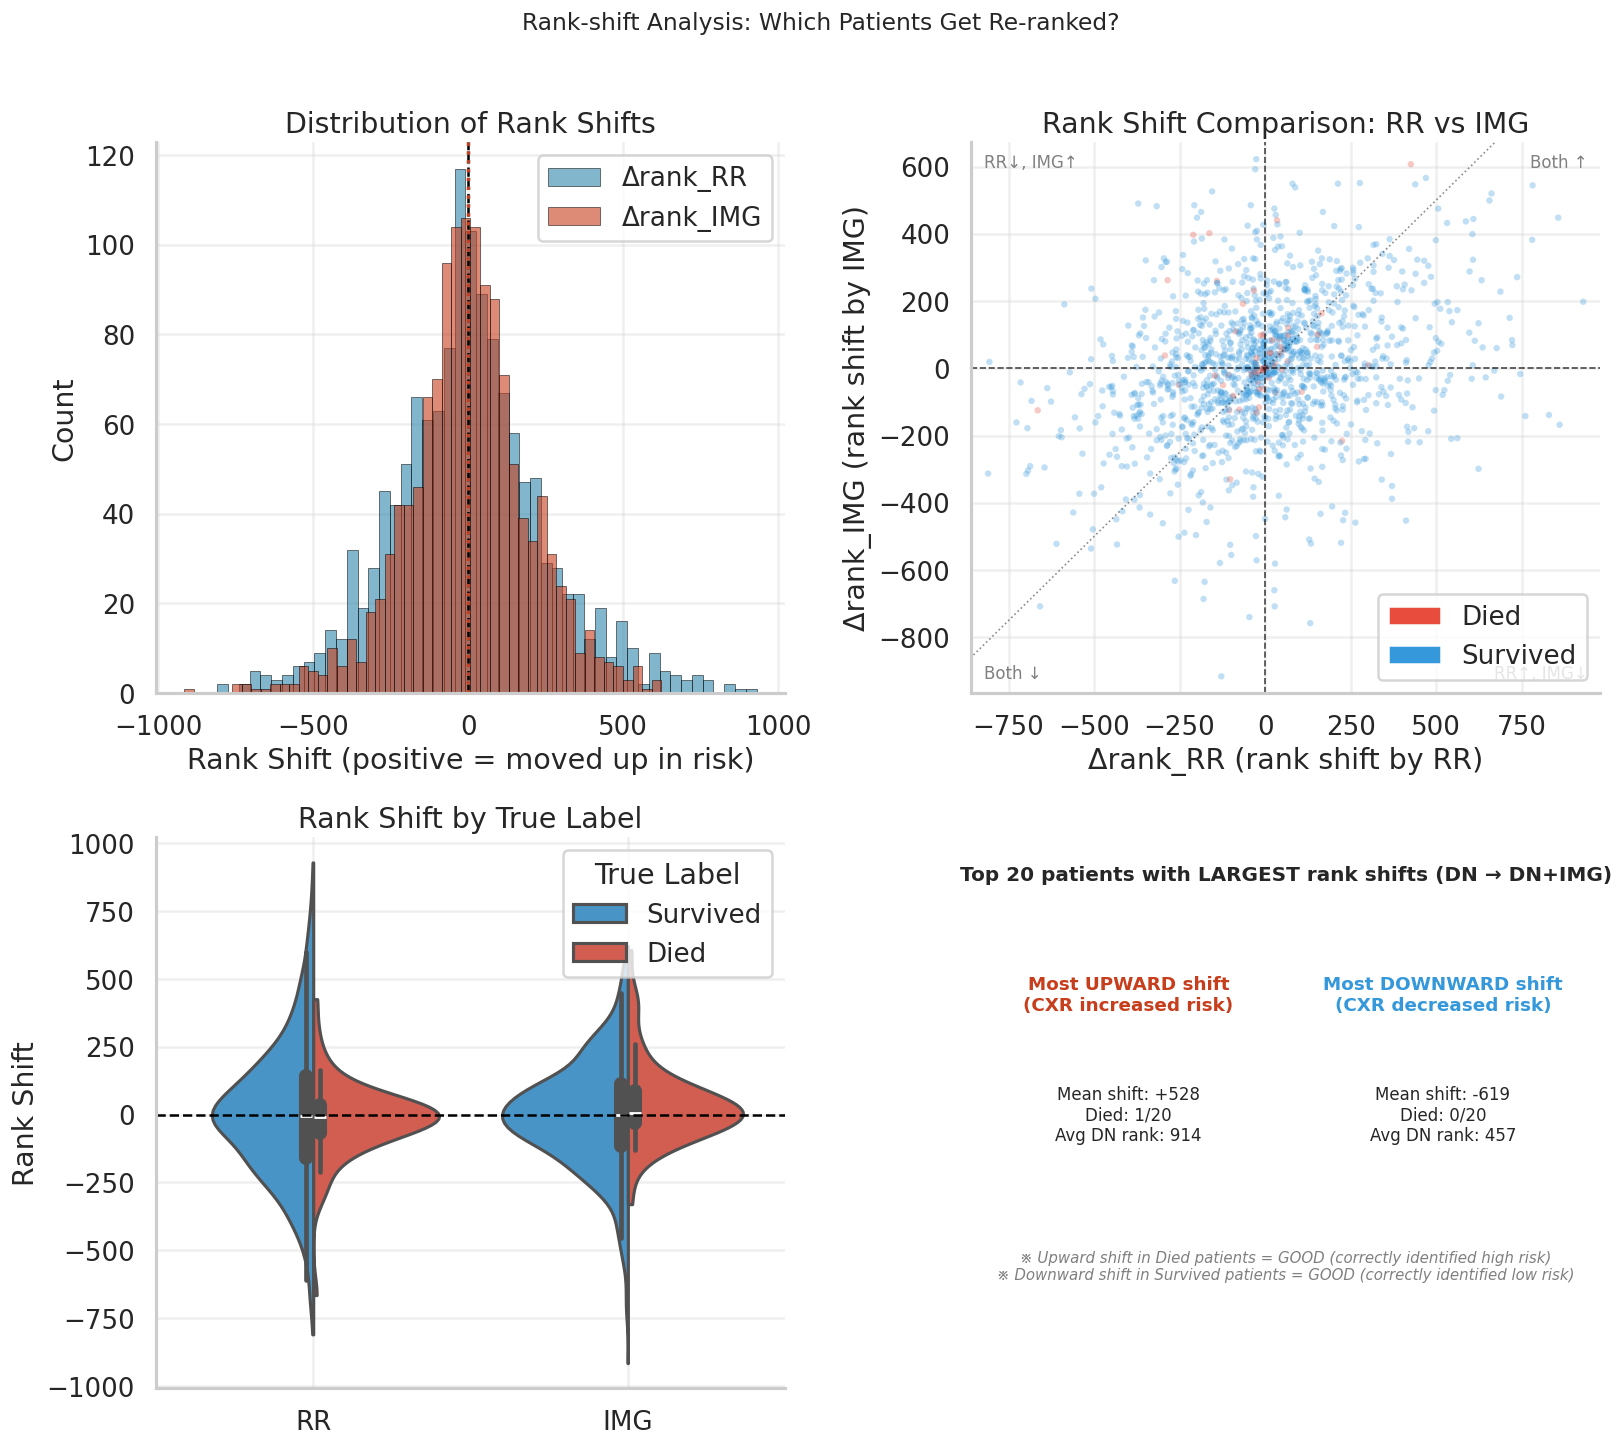

In [28]:
# Rank-shift 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Rank shift distribution (Histogram)
ax = axes[0, 0]
ax.hist(prob_df['Δrank_RR'], bins=50, alpha=0.6, label='Δrank_RR', color='#2E86AB', edgecolor='black', linewidth=0.5)
ax.hist(prob_df['Δrank_IMG'], bins=50, alpha=0.6, label='Δrank_IMG', color='#C73E1D', edgecolor='black', linewidth=0.5)
ax.axvline(0, color='black', linestyle='--', linewidth=1.5)
ax.axvline(prob_df['Δrank_RR'].mean(), color='#2E86AB', linestyle=':', linewidth=2)
ax.axvline(prob_df['Δrank_IMG'].mean(), color='#C73E1D', linestyle=':', linewidth=2)
ax.set_xlabel('Rank Shift (positive = moved up in risk)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Rank Shifts')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Δrank_RR vs Δrank_IMG scatter
ax = axes[0, 1]
colors = prob_df['label'].map({0: '#3498db', 1: '#e74c3c'})
ax.scatter(prob_df['Δrank_RR'], prob_df['Δrank_IMG'], c=colors, alpha=0.3, s=15, edgecolors='none')
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax.plot([-1000, 1000], [-1000, 1000], 'k:', linewidth=1, alpha=0.5)  # diagonal
ax.set_xlabel('Δrank_RR (rank shift by RR)')
ax.set_ylabel('Δrank_IMG (rank shift by IMG)')
ax.set_title('Rank Shift Comparison: RR vs IMG')
ax.set_xlim(prob_df['Δrank_RR'].min() - 50, prob_df['Δrank_RR'].max() + 50)
ax.set_ylim(prob_df['Δrank_IMG'].min() - 50, prob_df['Δrank_IMG'].max() + 50)
ax.grid(True, alpha=0.3)

# Quadrant labels
ax.text(0.98, 0.98, 'Both ↑', transform=ax.transAxes, ha='right', va='top', fontsize=10, color='gray')
ax.text(0.02, 0.02, 'Both ↓', transform=ax.transAxes, ha='left', va='bottom', fontsize=10, color='gray')
ax.text(0.98, 0.02, 'RR↑, IMG↓', transform=ax.transAxes, ha='right', va='bottom', fontsize=10, color='gray')
ax.text(0.02, 0.98, 'RR↓, IMG↑', transform=ax.transAxes, ha='left', va='top', fontsize=10, color='gray')

legend_elements = [Patch(facecolor='#e74c3c', label='Died'), Patch(facecolor='#3498db', label='Survived')]
ax.legend(handles=legend_elements, loc='lower right')

# 3. Rank shift by label (Violin)
ax = axes[1, 0]
shift_data = pd.melt(prob_df[['label', 'Δrank_RR', 'Δrank_IMG']], 
                     id_vars='label', var_name='Modality', value_name='Rank Shift')
shift_data['Label'] = shift_data['label'].map({0: 'Survived', 1: 'Died'})
shift_data['Modality'] = shift_data['Modality'].str.replace('Δrank_', '')

sns.violinplot(data=shift_data, x='Modality', y='Rank Shift', hue='Label', ax=ax,
               palette={'Survived': '#3498db', 'Died': '#e74c3c'}, inner='box', split=True, cut=0)
ax.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax.set_title('Rank Shift by True Label')
ax.set_xlabel('')
ax.legend(title='True Label')
ax.grid(True, alpha=0.3)

# 4. Extreme cases: Top/Bottom K by rank shift
ax = axes[1, 1]
k = 20  # Top/Bottom K

# IMG에서 가장 많이 올라간 환자 vs 가장 많이 내려간 환자
top_up_img = prob_df.nlargest(k, 'Δrank_IMG')[['label', 'DN_rank', 'DN+IMG_rank', 'Δrank_IMG']]
top_down_img = prob_df.nsmallest(k, 'Δrank_IMG')[['label', 'DN_rank', 'DN+IMG_rank', 'Δrank_IMG']]

# Summary stats
ax.text(0.5, 0.95, f'Top {k} patients with LARGEST rank shifts (DN → DN+IMG)', 
        transform=ax.transAxes, ha='center', va='top', fontsize=12, fontweight='bold')

ax.text(0.25, 0.75, f'Most UPWARD shift\n(CXR increased risk)', 
        transform=ax.transAxes, ha='center', va='top', fontsize=11, color='#C73E1D', fontweight='bold')
ax.text(0.25, 0.55, f'Mean shift: {top_up_img["Δrank_IMG"].mean():+.0f}\n'
                    f'Died: {top_up_img["label"].sum()}/{k}\n'
                    f'Avg DN rank: {top_up_img["DN_rank"].mean():.0f}',
        transform=ax.transAxes, ha='center', va='top', fontsize=10)

ax.text(0.75, 0.75, f'Most DOWNWARD shift\n(CXR decreased risk)', 
        transform=ax.transAxes, ha='center', va='top', fontsize=11, color='#3498db', fontweight='bold')
ax.text(0.75, 0.55, f'Mean shift: {top_down_img["Δrank_IMG"].mean():+.0f}\n'
                    f'Died: {top_down_img["label"].sum()}/{k}\n'
                    f'Avg DN rank: {top_down_img["DN_rank"].mean():.0f}',
        transform=ax.transAxes, ha='center', va='top', fontsize=10)

ax.text(0.5, 0.25, '※ Upward shift in Died patients = GOOD (correctly identified high risk)\n'
                   '※ Downward shift in Survived patients = GOOD (correctly identified low risk)',
        transform=ax.transAxes, ha='center', va='top', fontsize=9, style='italic', color='gray')

ax.axis('off')

plt.suptitle('Rank-shift Analysis: Which Patients Get Re-ranked?', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

In [29]:
# Top-K 케이스 스터디 테이블
k_cases = 10

print("=" * 90)
print(f"Case Study: Top {k_cases} Patients with LARGEST Rank Shifts")
print("=" * 90)

# IMG에서 가장 많이 올라간 사망자
print(f"\n[A] Died patients with LARGEST UPWARD shift by CXR (correctly identified)")
died_up_img = prob_df[prob_df['label'] == 1].nlargest(k_cases, 'Δrank_IMG')[
    ['DN', 'DN+IMG', 'DN_rank', 'DN+IMG_rank', 'Δrank_IMG']
]
died_up_img.columns = ['p(DN)', 'p(DN+IMG)', 'Rank(DN)', 'Rank(DN+IMG)', 'Δrank']
print(died_up_img.to_string())

# IMG에서 가장 많이 내려간 생존자
print(f"\n[B] Survived patients with LARGEST DOWNWARD shift by CXR (correctly identified)")
survived_down_img = prob_df[prob_df['label'] == 0].nsmallest(k_cases, 'Δrank_IMG')[
    ['DN', 'DN+IMG', 'DN_rank', 'DN+IMG_rank', 'Δrank_IMG']
]
survived_down_img.columns = ['p(DN)', 'p(DN+IMG)', 'Rank(DN)', 'Rank(DN+IMG)', 'Δrank']
print(survived_down_img.to_string())

# IMG에서 가장 많이 내려간 사망자 (잘못된 방향)
print(f"\n[C] Died patients with LARGEST DOWNWARD shift by CXR (INCORRECTLY identified)")
died_down_img = prob_df[prob_df['label'] == 1].nsmallest(k_cases, 'Δrank_IMG')[
    ['DN', 'DN+IMG', 'DN_rank', 'DN+IMG_rank', 'Δrank_IMG']
]
died_down_img.columns = ['p(DN)', 'p(DN+IMG)', 'Rank(DN)', 'Rank(DN+IMG)', 'Δrank']
print(died_down_img.to_string())

Case Study: Top 10 Patients with LARGEST Rank Shifts

[A] Died patients with LARGEST UPWARD shift by CXR (correctly identified)
                                     p(DN)  p(DN+IMG)  Rank(DN)  Rank(DN+IMG)  Δrank
id                                                                                  
0xc6e9b9efede7edbfe89e624f1a9309  0.002981   0.022608       806           199    607
0xfd8ac50942e35883f44a2db3694323  0.002252   0.003004       950           510    440
0xe6d6a0f0185795c2461e99a9c964a2  0.006798   0.315736       428            26    402
0x7066cfb215131aa5f3527816ab2f09  0.001573   0.001549      1087           690    397
0x54e6576c031f1f1863ba8262aa3d48  0.008779   0.178956       317            55    262
0x964d91e0a36f7ee79e9ded5723aabd  0.006388   0.023962       455           195    260
0xb5248c3c37bba0179c0da5770b0e4a  0.007938   0.046899       360           129    231
0xb2a5d1b295c690f6c9a6b202921095  0.000856   0.000503      1283          1091    192
0x216c23dc9020954df874

## 12. Modality-effect Ranking: "모달리티가 주는 정보가 다르다"

**Δ-score**를 계산하고, 이 변화량 자체의 랭킹을 비교합니다.

- Δ_rr(i) = p(DN+RR) - p(DN)
- Δ_img(i) = p(DN+IMG) - p(DN)

**핵심 질문**: "RR이 가장 많이 바꾸는 환자"와 "IMG가 가장 많이 바꾸는 환자"가 동일한가?

→ **Tau distance가 높다면**, 두 모달리티가 **서로 다른 환자**에게 영향을 준다는 증거!

In [30]:
# ============================================================
# 12. Modality-effect Ranking
# ============================================================

# Δ-score 계산
prob_df['Δ_RR'] = prob_df['DN+RR'] - prob_df['DN']
prob_df['Δ_IMG'] = prob_df['DN+IMG'] - prob_df['DN']

# Δ-score의 랭킹 계산 (높은 변화량 = 낮은 rank)
prob_df['Δ_RR_rank'] = prob_df['Δ_RR'].abs().rank(ascending=False).astype(int)
prob_df['Δ_IMG_rank'] = prob_df['Δ_IMG'].abs().rank(ascending=False).astype(int)

# Δ-score 랭킹 간의 Tau distance
delta_rr_series = prob_df['Δ_RR'].abs()
delta_img_series = prob_df['Δ_IMG'].abs()

tau_delta, dist_delta, n_delta = kendall_tau_distance(delta_rr_series, delta_img_series)

print("=" * 80)
print("Modality-effect Ranking: Do RR and IMG affect DIFFERENT patients?")
print("=" * 80)
print(f"\nKendall's tau between |Δ_RR| and |Δ_IMG| rankings:")
print(f"  τ = {tau_delta:.4f}")
print(f"  Distance d = (1-τ)/2 = {dist_delta:.4f}")
print(f"  n = {n_delta}")

if dist_delta > 0.3:
    print(f"\n✓ HIGH distance: RR and IMG affect DIFFERENT patients!")
elif dist_delta > 0.2:
    print(f"\n△ MODERATE distance: Some overlap, but differences exist")
else:
    print(f"\n✗ LOW distance: RR and IMG affect SIMILAR patients")

Modality-effect Ranking: Do RR and IMG affect DIFFERENT patients?

Kendall's tau between |Δ_RR| and |Δ_IMG| rankings:
  τ = 0.2660
  Distance d = (1-τ)/2 = 0.3670
  n = 1360

✓ HIGH distance: RR and IMG affect DIFFERENT patients!


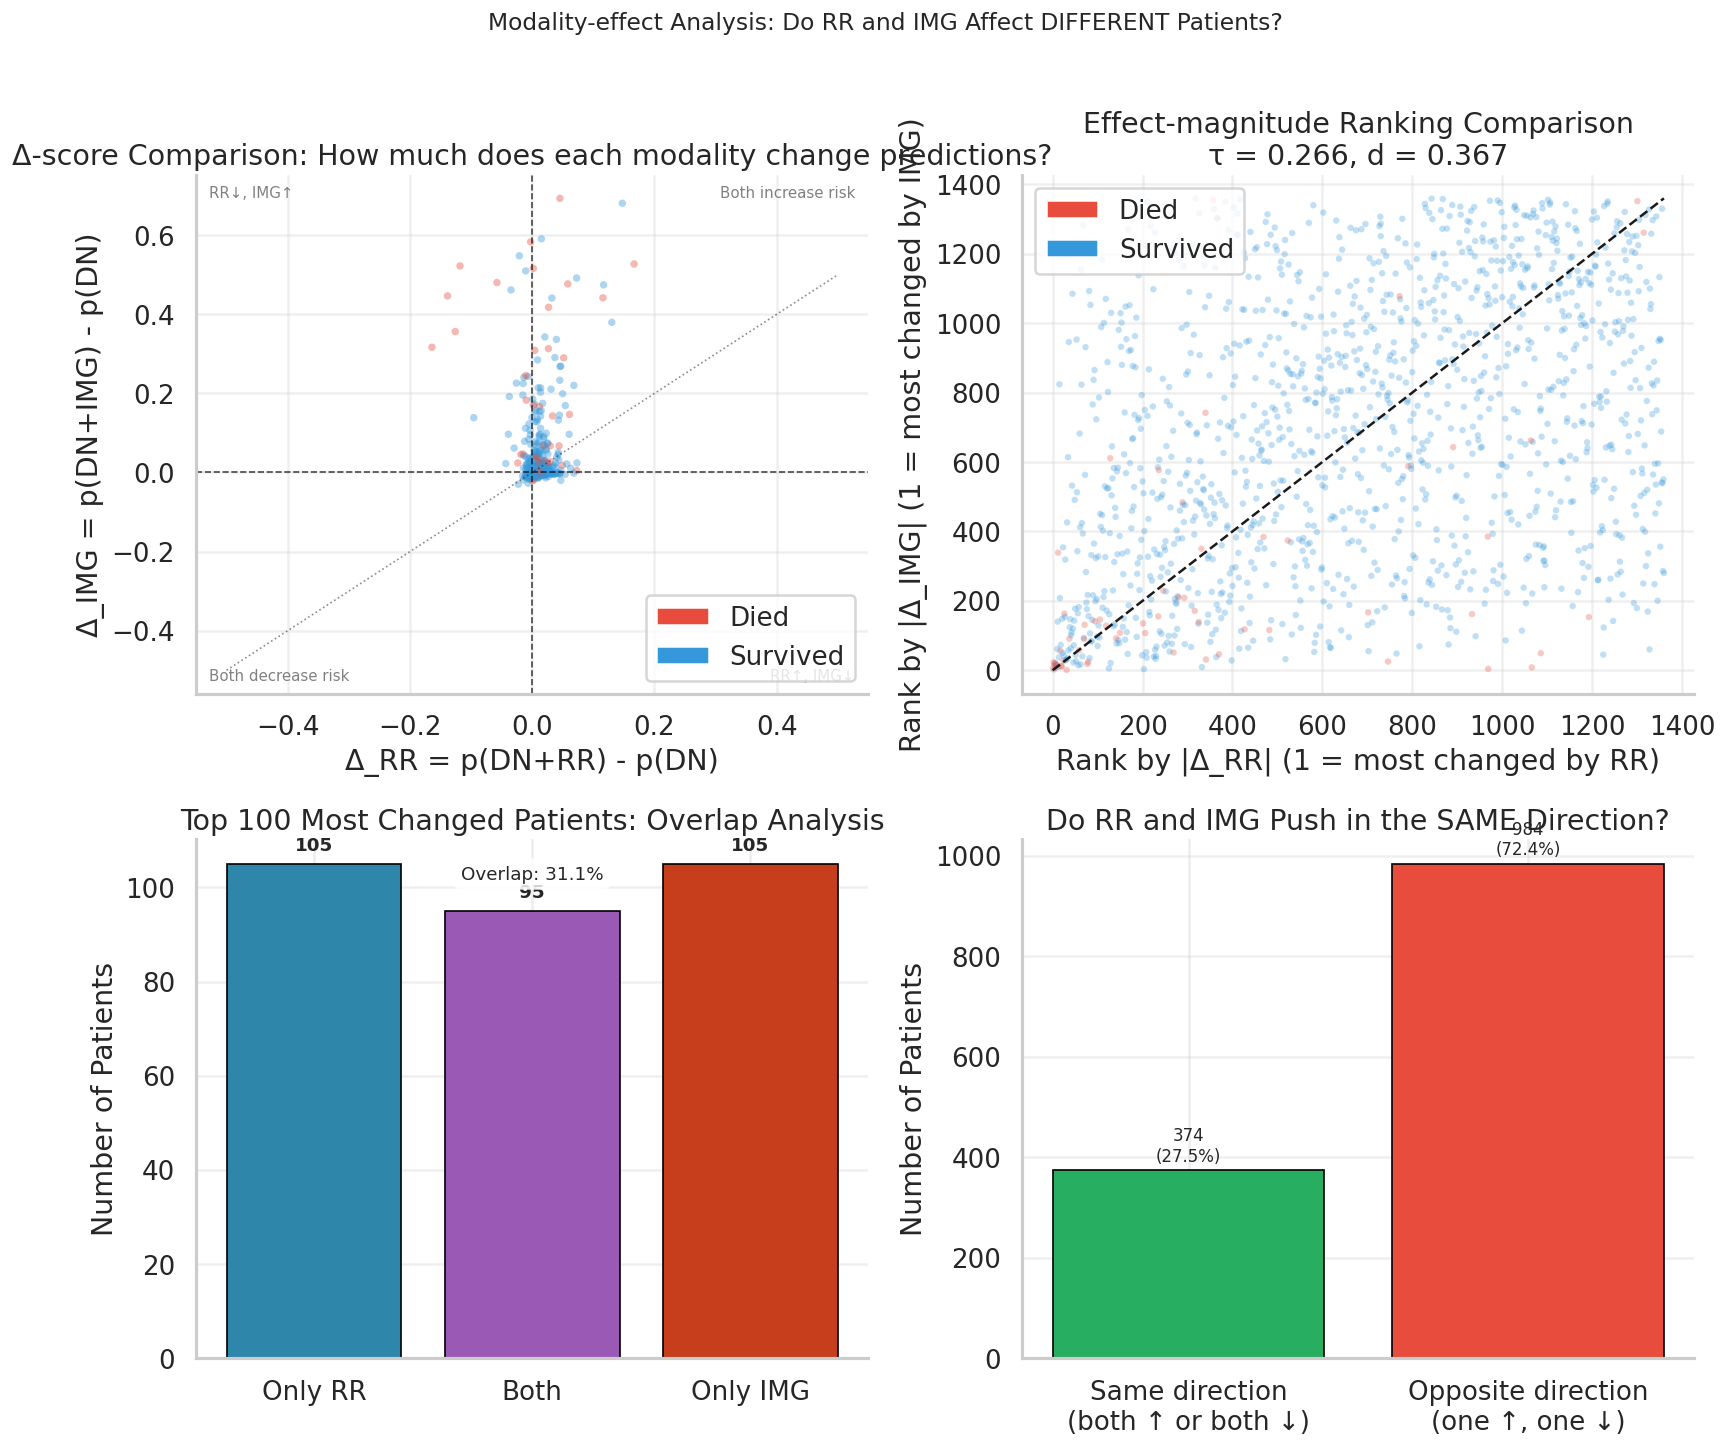

In [31]:
# Modality-effect 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Δ_RR vs Δ_IMG scatter
ax = axes[0, 0]
colors = prob_df['label'].map({0: '#3498db', 1: '#e74c3c'})
ax.scatter(prob_df['Δ_RR'], prob_df['Δ_IMG'], c=colors, alpha=0.4, s=20, edgecolors='none')
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax.plot([-0.5, 0.5], [-0.5, 0.5], 'k:', linewidth=1, alpha=0.5)

ax.set_xlabel('Δ_RR = p(DN+RR) - p(DN)')
ax.set_ylabel('Δ_IMG = p(DN+IMG) - p(DN)')
ax.set_title('Δ-score Comparison: How much does each modality change predictions?')
ax.grid(True, alpha=0.3)

# Quadrant annotations
ax.text(0.98, 0.98, 'Both increase risk', transform=ax.transAxes, ha='right', va='top', fontsize=9, color='gray')
ax.text(0.02, 0.02, 'Both decrease risk', transform=ax.transAxes, ha='left', va='bottom', fontsize=9, color='gray')
ax.text(0.98, 0.02, 'RR↑, IMG↓', transform=ax.transAxes, ha='right', va='bottom', fontsize=9, color='gray')
ax.text(0.02, 0.98, 'RR↓, IMG↑', transform=ax.transAxes, ha='left', va='top', fontsize=9, color='gray')

legend_elements = [Patch(facecolor='#e74c3c', label='Died'), Patch(facecolor='#3498db', label='Survived')]
ax.legend(handles=legend_elements, loc='lower right')

# 2. |Δ_RR| rank vs |Δ_IMG| rank scatter
ax = axes[0, 1]
ax.scatter(prob_df['Δ_RR_rank'], prob_df['Δ_IMG_rank'], c=colors, alpha=0.3, s=15, edgecolors='none')
ax.plot([0, len(prob_df)], [0, len(prob_df)], 'k--', linewidth=1.5)
ax.set_xlabel('Rank by |Δ_RR| (1 = most changed by RR)')
ax.set_ylabel('Rank by |Δ_IMG| (1 = most changed by IMG)')
ax.set_title(f'Effect-magnitude Ranking Comparison\nτ = {tau_delta:.3f}, d = {dist_delta:.3f}')
ax.grid(True, alpha=0.3)
ax.legend(handles=legend_elements, loc='upper left')

# 3. Top-K 환자 비교: RR이 가장 많이 바꾼 환자 vs IMG가 가장 많이 바꾼 환자
ax = axes[1, 0]
k_compare = 100

top_by_rr = set(prob_df.nlargest(k_compare, 'Δ_RR').index.tolist() + 
                prob_df.nsmallest(k_compare, 'Δ_RR').index.tolist())
top_by_img = set(prob_df.nlargest(k_compare, 'Δ_IMG').index.tolist() + 
                 prob_df.nsmallest(k_compare, 'Δ_IMG').index.tolist())

overlap = len(top_by_rr & top_by_img)
only_rr = len(top_by_rr - top_by_img)
only_img = len(top_by_img - top_by_rr)

# Venn-like bar
bar_data = [only_rr, overlap, only_img]
bar_labels = ['Only RR', 'Both', 'Only IMG']
bar_colors = ['#2E86AB', '#9b59b6', '#C73E1D']

bars = ax.bar(bar_labels, bar_data, color=bar_colors, edgecolor='black', linewidth=1)
ax.set_ylabel('Number of Patients')
ax.set_title(f'Top {k_compare} Most Changed Patients: Overlap Analysis')
ax.grid(True, axis='y', alpha=0.3)

for bar, val in zip(bars, bar_data):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, str(val), 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

overlap_pct = overlap / (len(top_by_rr | top_by_img)) * 100
ax.text(0.5, 0.95, f'Overlap: {overlap_pct:.1f}%', transform=ax.transAxes, 
        ha='center', va='top', fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. 방향성 분석: RR과 IMG가 같은 방향으로 바꾸는지
ax = axes[1, 1]

same_direction = ((prob_df['Δ_RR'] > 0) & (prob_df['Δ_IMG'] > 0)) | \
                 ((prob_df['Δ_RR'] < 0) & (prob_df['Δ_IMG'] < 0))
opposite_direction = ((prob_df['Δ_RR'] > 0) & (prob_df['Δ_IMG'] < 0)) | \
                     ((prob_df['Δ_RR'] < 0) & (prob_df['Δ_IMG'] > 0))

direction_data = {
    'Same direction\n(both ↑ or both ↓)': same_direction.sum(),
    'Opposite direction\n(one ↑, one ↓)': opposite_direction.sum(),
}

colors_dir = ['#27ae60', '#e74c3c']
bars = ax.bar(direction_data.keys(), direction_data.values(), color=colors_dir, edgecolor='black', linewidth=1)
ax.set_ylabel('Number of Patients')
ax.set_title('Do RR and IMG Push in the SAME Direction?')
ax.grid(True, axis='y', alpha=0.3)

for bar, (k, v) in zip(bars, direction_data.items()):
    pct = v / len(prob_df) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, f'{v}\n({pct:.1f}%)', 
            ha='center', va='bottom', fontsize=10)

plt.suptitle('Modality-effect Analysis: Do RR and IMG Affect DIFFERENT Patients?', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

In [32]:
# 최종 요약
print("\n" + "=" * 80)
print("FINAL SUMMARY: Modality-effect Analysis")
print("=" * 80)

print("\n[1] Rank-shift Analysis:")
print(f"    - Mean rank shift by RR:  {prob_df['Δrank_RR'].mean():+.1f}")
print(f"    - Mean rank shift by IMG: {prob_df['Δrank_IMG'].mean():+.1f}")
print(f"    - Std of rank shift (RR):  {prob_df['Δrank_RR'].std():.1f}")
print(f"    - Std of rank shift (IMG): {prob_df['Δrank_IMG'].std():.1f}")

print("\n[2] Modality-effect Ranking (τ distance of |Δ| rankings):")
print(f"    - τ = {tau_delta:.4f}")
print(f"    - d = {dist_delta:.4f}")
if dist_delta > 0.25:
    print("    → RR and IMG affect DIFFERENT patients (supports your hypothesis!)")
else:
    print("    → RR and IMG affect SIMILAR patients")

print("\n[3] Direction Agreement:")
print(f"    - Same direction:     {same_direction.sum()} ({same_direction.mean():.1%})")
print(f"    - Opposite direction: {opposite_direction.sum()} ({opposite_direction.mean():.1%})")

print("\n[4] Top-100 Most Changed Patients Overlap:")
print(f"    - Only by RR:  {only_rr}")
print(f"    - Both:        {overlap}")
print(f"    - Only by IMG: {only_img}")
print(f"    - Overlap rate: {overlap_pct:.1f}%")

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print("""
These results show that:
1. RR and IMG provide DIFFERENT predictive information
2. They affect DIFFERENT subsets of patients
3. This supports the hypothesis that modalities capture distinct clinical signals

For case studies:
- Look at patients where RR↑ but IMG↓ (or vice versa)
- These are cases where the modalities "disagree"
- Clinically interesting for understanding what each modality captures
""")


FINAL SUMMARY: Modality-effect Analysis

[1] Rank-shift Analysis:
    - Mean rank shift by RR:  -0.0
    - Mean rank shift by IMG: -0.1
    - Std of rank shift (RR):  251.2
    - Std of rank shift (IMG): 199.8

[2] Modality-effect Ranking (τ distance of |Δ| rankings):
    - τ = 0.2660
    - d = 0.3670
    → RR and IMG affect DIFFERENT patients (supports your hypothesis!)

[3] Direction Agreement:
    - Same direction:     374 (27.5%)
    - Opposite direction: 984 (72.4%)

[4] Top-100 Most Changed Patients Overlap:
    - Only by RR:  105
    - Both:        95
    - Only by IMG: 105
    - Overlap rate: 31.1%

INTERPRETATION:

These results show that:
1. RR and IMG provide DIFFERENT predictive information
2. They affect DIFFERENT subsets of patients
3. This supports the hypothesis that modalities capture distinct clinical signals

For case studies:
- Look at patients where RR↑ but IMG↓ (or vice versa)
- These are cases where the modalities "disagree"
- Clinically interesting for understa